# Import Libraries / Data Load

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from keras import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation, concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import f1_score,precision_recall_fscore_support
from matplotlib import gridspec
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import csv
import time

In [4]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_history(history):
    # accuracy plot 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_cm(y_true, y_hat, label_list):
    cnf_matrix = confusion_matrix(y_true, y_hat)
    np.set_printoptions(precision=2)
    from matplotlib import gridspec
    fig = plt.figure(figsize=(15, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    plt.subplot(gs[0])
    plot_confusion_matrix(cnf_matrix, title='Confusion matrix')
    plt.subplot(gs[1])
    plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')
    print("F1 Macro:", f1_score(y_true, y_hat, label_list, average='macro'))
    print("F1 Micro:", f1_score(y_true, y_hat, label_list, average='micro'))

In [12]:
dim = 64
import pickle
with open('features_fe.pickle','rb') as f:
    X_fe = pickle.load(f)
with open('X_cnn_64.pickle','rb') as f:
    X_cnn = pickle.load(f)
with open('X_bin.pickle','rb') as f:
    X_bin = pickle.load(f)
X_cnn = X_cnn.reshape(-1,dim,dim,1)
with open('y.pickle','rb') as f:
    y = pickle.load(f)

In [24]:
RANDON_STATE = 777
X_trainval, X_test, y_trainval, y_test = train_test_split(X_cnn, y, 
                                       test_size=10000, random_state=RANDON_STATE,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                       test_size=0.2, random_state=RANDON_STATE)

In [25]:
X_train.shape, X_val.shape

((130356, 64, 64, 1), (32590, 64, 64, 1))

In [ ]:

import tensorflow as tf

def FCN_model(len_classes=5, dropout_rate=0.2):
    
    # Input layer
    input = tf.keras.layers.Input(shape=(None, None, 3))

    # A convolution block
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Stack of convolution blocks

In [36]:
def build_model_bin():
    input_wbm_tensor = Input((None,None, 1))
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(input_wbm_tensor)
    pool_1 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_1)
    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_3)
    conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_4)
    conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)
    pool_5 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_5)
    """x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
predictions = tf.keras.layers.Activation('softmax')(x)"""
    
    dense_1 = Conv2D(128, (1,1), activation='relu')(pool_5)
    dense_2 = Conv2D(128, (1,1), activation='relu')(dense_1)
    prediction = Conv2D(9, (1,1), activation='softmax')(dense_2)

    model = models.Model(input_wbm_tensor, prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model
def train_model_bin(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=20, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
         validation_data=[X_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
    return model, list(set(np.argmax(y_train, axis=1)))

In [37]:
lr=0.0001
model_bin = build_model_bin()
model, y_hat = train_model_bin(model_bin, X_train, y_train, X_val, y_val)

ValueError: Error when checking target: expected conv2d_58 to have 4 dimensions, but got array with shape (130356, 9)

In [28]:
np.array(X_bin)[0].shape

(45, 48, 1)

In [18]:
lr = 0.0001

# Model Function

## Model 1 - CNN only

In [19]:
def build_model1():
    dim = 64
    input_wbm_tensor = Input((dim, dim, 1))
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(input_wbm_tensor)
    pool_1 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_1)
    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_3)
    conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_4)
    conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)
    pool_5 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_5)
    GAP = GlobalAveragePooling2D()(pool_5)
    dense_1 = Dense(128, activation='tanh')(GAP)
    dense_2 = Dense(128, activation='tanh')(dense_1)
    prediction = Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_wbm_tensor, prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model1(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=20, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
         validation_data=[X_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model1(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model1(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model1'+'*'*10+'\n')
    modelname = 'model1'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model1 = build_model1()
    model1, label_list = train_model1(model1, X_train_cnn, y_train, X_val_cnn, y_val)
    result_dict, cm = evaluate_model1(model1, X_test_cnn, y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model1


## Model 2 - FE+RF

In [20]:
def build_model2():
    model = RandomForestClassifier(n_estimators=100)
    return model

def train_model2(model, X_trainval, y_trainval):
    y_trainval_label = np.argmax(y_trainval, axis=1)
    model.fit(X_trainval, y_trainval_label)
    return model, list(set(np.argmax(y_trainval, axis=1)))

def evaluate_model2(model, X_test_fe, y_test, label_list, filename, result_dict, plot=True):
    y_hat = model.predict(X_test_fe)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model2(X_trainval_fe, y_trainval, X_test_fe, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model2'+'*'*10+'\n')
    modelname = 'model2'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model2 = build_model2()
    model2, label_list = train_model2(model2, X_trainval_fe, y_trainval)
    result_dict, cm = evaluate_model2(model2, X_test_fe, y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model2


## Model 3 - FE+NN

In [21]:
def build_model3():
    input_feature_vector = Input((59,))
    hidden_1 = Dense(128, activation='tanh')(input_feature_vector)
    hidden_2= Dense(128, activation='tanh')(hidden_1)
    prediction = layers.Dense(9, activation='softmax')(hidden_2)

    model = models.Model(input_feature_vector, prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model3(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=20, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
         validation_data=[X_val, y_val],
         epochs=epoch,
         batch_size=batch_size,callbacks=[es]
         )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model3(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm

def create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model3'+'*'*10+'\n')
    modelname = 'model3'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model3 = build_model3()
    model3, label_list = train_model3(model3, X_train_fe_n, y_train,  X_val_fe_n, y_val)
    result_dict, cm = evaluate_model3(model3, X_test_fe_n, y_test, label_list, filename, result_dict, plot=False)
    return result_dict, cm, model3


## Model 4 - Joint Model

In [22]:
def build_model4():
    dim = 64
    input_wbm_tensor = Input((dim, dim, 1))
    conv_1 = Conv2D(16, (3,3), activation='relu', padding='same')(input_wbm_tensor)
    pool_1 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_1)
    conv_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_2)
    conv_3 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_3)
    conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_4)
    conv_5 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_4)
    pool_5 = MaxPool2D(pool_size=(2, 2),strides=2 ,padding='same')(conv_5)
    GAP = GlobalAveragePooling2D()(pool_5)

    input_feature_vector = Input((59,))

    concat_vector = concatenate([GAP, input_feature_vector])

    concat_hidden_1 = layers.Dense(128, activation='tanh')(concat_vector)
    concat_hidden_2 = layers.Dense(128, activation='tanh')(concat_hidden_1)
    prediction = layers.Dense(9, activation='softmax')(concat_hidden_2)

    model = models.Model([input_wbm_tensor, input_feature_vector], prediction)
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def train_model4(model, X_train, y_train, X_val, y_val):
    epoch=1000
    batch_size = 32
    es = EarlyStopping(monitor='val_loss', patience=20, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,
             validation_data=[X_val, y_val],
             epochs=epoch,
             batch_size=batch_size,callbacks=[es]
             )
    return model, list(set(np.argmax(y_train, axis=1)))

def evaluate_model4(model, X_test, y_test, label_list, filename, result_dict, plot=True):
    y_hat=model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model4'+'*'*10+'\n')
    modelname = 'model4'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model4 = build_model4()
    model4, label_list = train_model4(model4, [X_train_cnn, X_train_fe_n], y_train, [X_val_cnn, X_val_fe_n], y_val)
    result_dict, cm = evaluate_model4(model4, [X_test_cnn, X_test_fe_n], y_test, label_list, filename, result_dict,plot=False)
    return result_dict, cm, model4
    


## Model 5 - Stacking Model

In [23]:
def build_model5():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.0001, fit_intercept=False)
    return model

def train_model5_val(model5, model1, model2, X_val_cnn, X_val_fe, X_test_cnn, X_test_fe, 
                 y_val, y_test):
    prob_val_cnn = model1.predict(X_val_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_val_fe = model2.predict_proba(X_val_fe) 
    prob_test_fe = model2.predict_proba(X_test_fe)
    
    y_val_label = np.argmax(y_val, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_val_concat = np.concatenate((prob_val_cnn, prob_val_fe), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fe), axis=1)
    model5.fit(prob_val_concat, y_val)
    return model5, prob_test_concat, list(set(np.argmax(y_val, axis=1)))

def evaluate_model5(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model5(model_1, model_2, X_val_cnn, X_val_fe, y_val,
           X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model5'+'*'*10+'\n')
    modelname = 'model5'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model5 = build_model5()
    model5, prob_test_concat5, label_list =train_model5_val(model5, model_1, model_2, X_val_cnn, X_val_fe, 
                                     X_test_cnn, X_test_fe, y_val, y_test)
    result_dict, cm = evaluate_model5(model5, prob_test_concat5, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model5, prob_test_concat5
    


In [24]:
# train, val이 나눠짐
def build_model6():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.0001, fit_intercept=False)
    return model

def train_model6_val(model6, model1, model3, X_val_cnn, X_val_fe_n, X_test_cnn, 
                 X_test_fe_n, y_val,y_test):
    prob_val_cnn = model1.predict(X_val_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_val_fnn = model3.predict(X_val_fe_n) 
    prob_test_fnn = model3.predict(X_test_fe_n)
    
    y_val_label = np.argmax(y_val, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_val_concat = np.concatenate((prob_val_cnn, prob_val_fnn), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fnn), axis=1)
    model6.fit(prob_val_concat, y_val)
    return model6, prob_test_concat, list(set(np.argmax(y_val, axis=1)))

def evaluate_model6(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model6_val(model_1, model_3, X_val_cnn, X_val_fe_n, y_val,
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model6'+'*'*10+'\n')
    modelname = 'model6'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model6 = build_model6()
    model6, prob_test_concat6, label_list =train_model6_val(model6, model_1, model_3, X_val_cnn, 
                                         X_val_fe_n, X_test_cnn, X_test_fe_n, y_val, y_test)
    result_dict, cm = evaluate_model6(model6, prob_test_concat6, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model6.coef_, model6, prob_test_concat6


In [25]:
def build_model6():
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=0.1, fit_intercept=False)
    return model

def train_model6(model6, model1, model3, X_trainval_cnn, X_trainval_fe_normalized, X_test_cnn, 
                 X_test_fe_normalized, y_trainval,y_test):
    prob_trainval_cnn = model1.predict(X_trainval_cnn) 
    prob_test_cnn = model1.predict(X_test_cnn)
    
    prob_trainval_fnn = model3.predict(X_trainval_fe_normalized) 
    prob_test_fnn = model3.predict(X_test_fe_normalized)
    
    y_trainval_label = np.argmax(y_trainval, axis=1)
    y_test_label = np.argmax(y_test, axis=1)
    
    prob_trainval_concat = np.concatenate((prob_trainval_cnn, prob_trainval_fnn), axis=1)
    prob_test_concat = np.concatenate((prob_test_cnn, prob_test_fnn), axis=1)
    model6.fit(prob_trainval_concat, y_trainval)
    return model6, prob_test_concat, list(set(np.argmax(y_trainval, axis=1)))

def evaluate_model6(model, prob_test_concat, y_test, label_list, filename, result_dict, plot=True):
    prob = model.predict(prob_test_concat)
    y_hat = np.argmax(prob, axis=1)
    y_test_label = np.argmax(y_test,axis=1)
    result_dict['macro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='macro'))
    result_dict['micro'].append(f1_score(y_test_label, y_hat, labels=label_list, average='micro'))
    cm = confusion_matrix(y_test_label, y_hat)
    plot_cm(y_test_label, y_hat, label_list)
    plt.savefig(filename)
    if plot != True:
        plt.close()
    return result_dict, cm


def create_model6(model_1, model_3, X_trainval_cnn, X_trainval_fe_n, y_trainval,
           X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep):
    print('\n'+'*'*10+'model6'+'*'*10+'\n')
    modelname = 'model6'
    filename = fn.format(ts=n_trnval, rep=rep, model=modelname)
    model6 = build_model6()
    model6, prob_test_concat6, label_list =train_model6(model6, model_1, model_3, X_trainval_cnn, 
                                         X_trainval_fe_n, X_test_cnn, X_test_fe_n, y_trainval, y_test)
    result_dict, cm = evaluate_model6(model6, prob_test_concat6, y_test, label_list,
                                      filename, result_dict,plot=False)
    return result_dict, cm, model6.coef_, model6, prob_test_concat6


# Sampling Training Data

In [12]:
def experiment(savefile, replication=5, random_seed=3):
    model_list = ['model1', 'model2', 'model3', 'model4', 'model5','model6']
    pattern_list = [0, 1, 2, 3, 4, 5, 6, 7 ,8]
    n_trnval_list = [500,5000,50000,162946]
    f1_dict = {}
    model6_list = []
    for t in n_trnval_list:
        f1_dict[t] = {}
        for label in pattern_list:
            f1_dict[t][label] = {}
            for model in model_list:
                f1_dict[t][label][str(model)] = []
    
    with open(savefile+'.csv', 'w', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1_macro','model2_macro','model3_macro','model4_macro','model5_macro','model6_macro',
                              'model1_micro','model2_micro','model3_micro','model4_micro','model5_micro','model6_micro']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
    with open(savefile+'2.csv', 'w', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1','model2','model3','model4','model5','model6']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
    if not os.path.exists('./savefile'):
        os.makedirs('./'+savefile)
    for rep in range(replication):
        RANDON_STATE = 20200321+rep+random_seed
        X_trainval_cnn_big, X_test_cnn, y_trainval_big, y_test = train_test_split(X_cnn, y, 
                                       test_size=10000, random_state=RANDON_STATE,stratify=y)
        X_trainval_fe_big, X_test_fe = train_test_split(X_fe, test_size=10000, 
                                                        random_state=RANDON_STATE,stratify=y)
        start_time = time.time()
        print('\n','&'*20,rep+1,'replication','&'*20,'\n\n')
        idx_list = [np.where(np.argmax(y_test,axis=1)==i)[0] for i in range(9)]
        for n_trnval in n_trnval_list:
            # Sampling
            print('\n','@'*20,rep+1,'replication',n_trnval,'@'*20,'\n\n')
            global fn
            fn = './'+savefile+'/result_{rep}_{ts:04d}_{model}.png'
            np.random.seed(20200321+n_trnval*(rep+random_seed))
            rand_id = np.random.choice(len(X_trainval_fe_big), n_trnval, replace=False)
            X_trainval_cnn = X_trainval_cnn_big[rand_id]
            X_trainval_fe = X_trainval_fe_big[rand_id]

            y_trainval = y_trainval_big[rand_id]
            # Split
            X_train_cnn, X_val_cnn, y_train, y_val= train_test_split(X_trainval_cnn, 
                                                    y_trainval, test_size=0.2, random_state=RANDON_STATE)
            X_train_fe, X_val_fe = train_test_split(X_trainval_fe, test_size=0.2, random_state=RANDON_STATE)
            
            mean, std = np.mean(X_train_fe,axis=0), np.std(X_train_fe,axis=0)
            X_train_fe_n, X_val_fe_n, X_test_fe_n, X_trainval_fe_n = (X_train_fe-mean)/std, (X_val_fe-mean)/std, (X_test_fe-mean)/std, (X_trainval_fe-mean)/std
            
            # Train and Evaluate Each Model
            result_dict = {'macro':[],'micro':[]}
            label_list = list(set(np.argmax(y_trainval,axis=1)))
            print('label_list',list(set(np.argmax(y_trainval,axis=1))))
            print('label_list',list(set(np.argmax(y_train,axis=1))))

            result_dict, cm, model1 = create_model1(X_train_cnn, y_train, X_val_cnn, y_val, 
                                              X_test_cnn, y_test,result_dict, n_trnval, rep)
            result_dict, cm, model2 = create_model2(X_trainval_fe, y_trainval, 
                                              X_test_fe, y_test, result_dict, n_trnval, rep)
            result_dict, cm ,model3= create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, 
                                             X_test_fe_n, y_test, result_dict,  n_trnval, rep)
            result_dict, cm, model4= create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
                                             X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
            result_dict, cm, model5, prob_test_concat5 = create_model5(model1, model2, X_val_cnn, X_val_fe, y_trainval, 
                                             X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep)
            result_dict, cm, coeff, model6, prob_test_concat6 = create_model6(model1, model3, X_val_cnn, 
                        X_val_fe_n, y_val, X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
            
            for pattern_num in pattern_list:
                for model in model_list:
                    if model == 'model2':
                        y_hat = np.argmax(model2.predict_proba(X_test_fe[idx_list[pattern_num]]),axis=1)
                    elif model == 'model4':
                        y_hat = np.argmax(model4.predict([X_test_cnn[idx_list[pattern_num]], 
                                       X_test_fe_n[idx_list[pattern_num]]]),axis=1)
                    elif model == 'model6':
                        y_hat = np.argmax(model6.predict(prob_test_concat6[idx_list[pattern_num]]),axis=1)    
                    elif model =='model1':
                        y_hat = np.argmax(model1.predict(X_test_cnn[idx_list[pattern_num]]),axis=1)
                    elif model == 'model3':
                        y_hat = np.argmax(model3.predict(X_test_fe_n[idx_list[pattern_num]]),axis=1)
                    elif model == 'model5':
                        y_hat = np.argmax(model5.predict(prob_test_concat5[idx_list[pattern_num]]),axis=1)
                    y_true = np.argmax(y_test[idx_list[pattern_num]],axis=1)
                    fscore = np.max(f1_score(y_true, y_hat, average=None))
                    f1_dict[n_trnval][pattern_num][str(model)].append(fscore)
            
            model6_list.append(model6)
            # Record result
            with open(savefile+'.csv', 'a', newline='') as csvfile:
                fieldnames = ['training_size', 
                              'model1_macro','model2_macro','model3_macro','model4_macro','model5_macro',
                              'model6_macro',
                              'model1_micro','model2_micro','model3_micro','model4_micro','model5_micro',
                              'model6_micro']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow({'training_size': n_trnval, 
                                 'model1_macro': result_dict['macro'][0],'model2_macro': result_dict['macro'][1],
                                 'model3_macro': result_dict['macro'][2],'model4_macro': result_dict['macro'][3],
                                 'model5_macro': result_dict['macro'][4],'model6_macro': result_dict['macro'][5],
                                 'model1_micro': result_dict['micro'][0],'model2_micro': result_dict['micro'][1],
                                 'model3_micro': result_dict['micro'][2],'model4_micro': result_dict['micro'][3],
                                 'model5_micro': result_dict['micro'][4],'model6_micro': result_dict['micro'][5],
                                 })
        
        print('\n\n',(time.time()-start_time)/60,'min per replication\n\n')
    for n_trnval in n_trnval_list:
        for pattern in pattern_list:
            for model in model_list:
                f1_dict[n_trnval][pattern][model] = np.mean(f1_dict[n_trnval][pattern][model])
    with open(savefile+'_2.csv', 'w', newline='') as csvfile:
        fieldnames = ['pattern', 
                      'model1','model2','model3','model4','model5','model6']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for n_trnval in n_trnval_list:
            writer.writerow({'pattern':n_trnval})
            for pattern in pattern_list:
                writer.writerow({'pattern': pattern,
                                 'model1':f1_dict[n_trnval][pattern]['model1'],
                                 'model2':f1_dict[n_trnval][pattern]['model2'],
                                 'model3':f1_dict[n_trnval][pattern]['model3'],
                                 'model4':f1_dict[n_trnval][pattern]['model4'],
                                 'model5':f1_dict[n_trnval][pattern]['model5'],
                                 'model6':f1_dict[n_trnval][pattern]['model6']})
    return model6_list

In [26]:
savefile = '0403_e'
model6_list = experiment(savefile, replication=1)


 &&&&&&&&&&&&&&&&&&&& 1 replication &&&&&&&&&&&&&&&&&&&& 



 @@@@@@@@@@@@@@@@@@@@ 1 replication 500 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 400 samples, validate on 100 samples
Epoch 1/500
400/400 [==============================] - 0s 706us/step - loss: 1.8799 - accuracy: 0.7925 - val_loss: 1.3507 - val_accuracy: 0.8700
Epoch 2/500
400/400 [==============================] - 0s 227us/step - loss: 1.0300 - accuracy: 0.8425 - val_loss: 0.7208 - val_accuracy: 0.8700
Epoch 3/500
400/400 [==============================] - 0s 238us/step - loss: 0.8244 - accuracy: 0.8425 - val_loss: 0.6969 - val_accuracy: 0.8700
Epoch 4/500
400/400 [==============================] - 0s 236us/step - loss: 0.7507 - accuracy: 0.8425 - val_loss: 0.7076 - val_accuracy: 0.8700
Epoch 5/500
400/400 [==============================] - 0s 239us/step - loss: 0.7417 - accuracy: 0.8425 - val_loss: 0.6764 - val_accuracy: 0.8

400/400 [==============================] - 0s 78us/step - loss: 0.1632 - accuracy: 0.9725 - val_loss: 0.2105 - val_accuracy: 0.9400
Epoch 50/500
400/400 [==============================] - 0s 82us/step - loss: 0.1584 - accuracy: 0.9750 - val_loss: 0.2088 - val_accuracy: 0.9300
Epoch 51/500
400/400 [==============================] - 0s 81us/step - loss: 0.1525 - accuracy: 0.9750 - val_loss: 0.2040 - val_accuracy: 0.9300
Epoch 52/500
400/400 [==============================] - 0s 79us/step - loss: 0.1479 - accuracy: 0.9750 - val_loss: 0.2005 - val_accuracy: 0.9300
Epoch 53/500
400/400 [==============================] - 0s 85us/step - loss: 0.1429 - accuracy: 0.9750 - val_loss: 0.1988 - val_accuracy: 0.9300
Epoch 54/500
400/400 [==============================] - 0s 84us/step - loss: 0.1386 - accuracy: 0.9750 - val_loss: 0.1958 - val_accuracy: 0.9300
Epoch 55/500
400/400 [==============================] - 0s 87us/step - loss: 0.1346 - accuracy: 0.9750 - val_loss: 0.1927 - val_accuracy: 0.930

Epoch 28/500
400/400 [==============================] - 0s 217us/step - loss: 0.1646 - accuracy: 0.9600 - val_loss: 0.1897 - val_accuracy: 0.9500
Epoch 29/500
400/400 [==============================] - 0s 222us/step - loss: 0.1585 - accuracy: 0.9575 - val_loss: 0.1870 - val_accuracy: 0.9400
Epoch 30/500
400/400 [==============================] - 0s 219us/step - loss: 0.1552 - accuracy: 0.9600 - val_loss: 0.1833 - val_accuracy: 0.9500
Epoch 31/500
400/400 [==============================] - 0s 213us/step - loss: 0.1505 - accuracy: 0.9600 - val_loss: 0.1816 - val_accuracy: 0.9400
Epoch 32/500
400/400 [==============================] - 0s 218us/step - loss: 0.1480 - accuracy: 0.9600 - val_loss: 0.1794 - val_accuracy: 0.9500
Epoch 33/500
400/400 [==============================] - 0s 228us/step - loss: 0.1463 - accuracy: 0.9600 - val_loss: 0.1783 - val_accuracy: 0.9500
Epoch 34/500
400/400 [==============================] - 0s 212us/step - loss: 0.1443 - accuracy: 0.9675 - val_loss: 0.1747 -

4000/4000 [==============================] - 1s 203us/step - loss: 0.1194 - accuracy: 0.9657 - val_loss: 0.1783 - val_accuracy: 0.9450
Epoch 29/500
4000/4000 [==============================] - 1s 199us/step - loss: 0.1127 - accuracy: 0.9647 - val_loss: 0.1756 - val_accuracy: 0.9440
Epoch 30/500
4000/4000 [==============================] - 1s 200us/step - loss: 0.1101 - accuracy: 0.9663 - val_loss: 0.1570 - val_accuracy: 0.9500
Epoch 31/500
4000/4000 [==============================] - 1s 199us/step - loss: 0.1031 - accuracy: 0.9690 - val_loss: 0.1843 - val_accuracy: 0.9470
Epoch 32/500
4000/4000 [==============================] - 1s 200us/step - loss: 0.1006 - accuracy: 0.9703 - val_loss: 0.1578 - val_accuracy: 0.9500
Epoch 33/500
4000/4000 [==============================] - 1s 201us/step - loss: 0.0932 - accuracy: 0.9725 - val_loss: 0.1582 - val_accuracy: 0.9500
Epoch 34/500
4000/4000 [==============================] - 1s 193us/step - loss: 0.0981 - accuracy: 0.9693 - val_loss: 0.1811 

Epoch 11/500
40000/40000 [==============================] - 8s 197us/step - loss: 0.0823 - accuracy: 0.9721 - val_loss: 0.1152 - val_accuracy: 0.9613
Epoch 12/500
40000/40000 [==============================] - 8s 192us/step - loss: 0.0751 - accuracy: 0.9748 - val_loss: 0.0976 - val_accuracy: 0.9672
Epoch 13/500
40000/40000 [==============================] - 8s 196us/step - loss: 0.0718 - accuracy: 0.9760 - val_loss: 0.0990 - val_accuracy: 0.9678
Epoch 14/500
40000/40000 [==============================] - 8s 197us/step - loss: 0.0669 - accuracy: 0.9778 - val_loss: 0.1009 - val_accuracy: 0.9651
Epoch 15/500
40000/40000 [==============================] - 8s 196us/step - loss: 0.0629 - accuracy: 0.9778 - val_loss: 0.0956 - val_accuracy: 0.9665
Epoch 16/500
40000/40000 [==============================] - 8s 196us/step - loss: 0.0588 - accuracy: 0.9798 - val_loss: 0.1086 - val_accuracy: 0.9660
Epoch 17/500
40000/40000 [==============================] - 8s 196us/step - loss: 0.0535 - accuracy:

c:\users\user\anaconda3\envs\tf2.0\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.40234e-08): result may not be accurate.
  overwrite_a=True).T


Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8440020590271429
F1 Micro: 0.9735

 @@@@@@@@@@@@@@@@@@@@ 1 replication 162946 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 130356 samples, validate on 32590 samples
Epoch 1/500
130356/130356 [==============================] - 26s 201us/step - loss: 0.2497 - accuracy: 0.9326 - val_loss: 0.1331 - val_accuracy: 0.9577
Epoch 2/500
130356/130356 [==============================] - 25s 191us/step - loss: 0.1212 - accuracy: 0.9612 - val_loss: 0.1185 - val_accuracy: 0.9621
Epoch 3/500
130356/130356 [==============================] - 25s 192us/step - loss: 0.1020 - accuracy: 0.9673 - val_loss: 0.0993 - val_accuracy: 0.9670
Epoch 4/500
130356/130356 [==============================] - 25s 190us/step - loss: 0.0909 - accuracy: 0.9701 - val_loss: 0.0831 - val_accuracy: 0.9723
Epoch 5/500
130356/130356 [=========================

c:\users\user\anaconda3\envs\tf2.0\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.74298e-09): result may not be accurate.
  overwrite_a=True).T


Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.9001147725862668
F1 Micro: 0.9799


 40.44081159830093 min per replication




[Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)]

In [27]:
savefile = '0430'
model_list = ['model1', 'model2', 'model3', 'model4', 'model5','model6']
pattern_list = [0, 1, 2, 3, 4, 5, 6, 7 ,8]
n_trnval_list = [500,5000,50000,162946]
coeff_dict = {}
f1_dict = {}
model6_list = []
for k in n_trnval_list:
    coeff_dict[k] = []
for t in n_trnval_list:
    f1_dict[t] = {}
    for label in pattern_list:
        f1_dict[t][label] = {}
        for model in model_list:
            f1_dict[t][label][str(model)] = []

replication=10
random_seed=777
if not os.path.exists('./'+savefile):
    os.makedirs('./'+savefile)
for rep in range(replication):
    RANDON_STATE = 20200430+rep+random_seed
    X_trainval_cnn_big, X_test_cnn, y_trainval_big, y_test = train_test_split(X_cnn, y, 
                                   test_size=10000, random_state=RANDON_STATE,stratify=y)
    X_trainval_fe_big, X_test_fe = train_test_split(X_fe, test_size=10000, 
                                                    random_state=RANDON_STATE,stratify=y)
    start_time = time.time()
    print('\n','&'*20,rep+1,'replication','&'*20,'\n\n')
    idx_list = [np.where(np.argmax(y_test,axis=1)==i)[0] for i in range(9)]
    for n_trnval in n_trnval_list:
        # Sampling
        print('\n','@'*20,rep+1,'replication',n_trnval,'@'*20,'\n\n')
        global fn
        fn = './'+savefile+'/result_{rep}_{ts:04d}_{model}.png'
        np.random.seed(20200321+n_trnval*(rep+random_seed))
        rand_id = np.random.choice(len(X_trainval_fe_big), n_trnval, replace=False)
        X_trainval_cnn = X_trainval_cnn_big[rand_id]
        X_trainval_fe = X_trainval_fe_big[rand_id]

        y_trainval = y_trainval_big[rand_id]
        # Split
        X_train_cnn, X_val_cnn, y_train, y_val= train_test_split(X_trainval_cnn, 
                                                y_trainval, test_size=0.2, random_state=RANDON_STATE)
        X_train_fe, X_val_fe = train_test_split(X_trainval_fe, test_size=0.2, random_state=RANDON_STATE)

        mean, std = np.mean(X_train_fe,axis=0), np.std(X_train_fe,axis=0)
        X_train_fe_n, X_val_fe_n, X_test_fe_n, X_trainval_fe_n = (X_train_fe-mean)/std, (X_val_fe-mean)/std, (X_test_fe-mean)/std, (X_trainval_fe-mean)/std

        # Train and Evaluate Each Model
        result_dict = {'macro':[],'micro':[]}
        label_list = list(set(np.argmax(y_trainval,axis=1)))
        print('label_list',list(set(np.argmax(y_trainval,axis=1))))
        print('label_list',list(set(np.argmax(y_train,axis=1))))

        result_dict, cm, model1 = create_model1(X_train_cnn, y_train, X_val_cnn, y_val, 
                                          X_test_cnn, y_test,result_dict, n_trnval, rep)
        result_dict, cm, model2 = create_model2(X_trainval_fe, y_trainval, 
                                          X_test_fe, y_test, result_dict, n_trnval, rep)
        result_dict, cm ,model3= create_model3(X_train_fe_n, y_train, X_val_fe_n, y_val, 
                                         X_test_fe_n, y_test, result_dict,  n_trnval, rep)
        result_dict, cm, model4= create_model4(X_train_cnn, X_train_fe_n, y_train, X_val_cnn, X_val_fe_n, y_val, 
                                         X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)
        result_dict, cm, model5, prob_test_concat5 = create_model5(model1, model2, X_trainval_cnn, X_trainval_fe, y_trainval, 
                                         X_test_cnn, X_test_fe, y_test, result_dict, n_trnval, rep)
        result_dict, cm, coeff, model6, prob_test_concat6 = create_model6(model1, model3, X_trainval_cnn, X_trainval_fe_n, 
                     y_trainval, X_test_cnn, X_test_fe_n, y_test, result_dict, n_trnval, rep)

        for pattern_num in pattern_list:
            for model in model_list:
                if model == 'model2':
                    y_hat = np.argmax(model2.predict_proba(X_test_fe[idx_list[pattern_num]]),axis=1)
                elif model == 'model4':
                    y_hat = np.argmax(model4.predict([X_test_cnn[idx_list[pattern_num]], 
                                   X_test_fe_n[idx_list[pattern_num]]]),axis=1)
                elif model == 'model6':
                    y_hat = np.argmax(model6.predict(prob_test_concat6[idx_list[pattern_num]]),axis=1)    
                elif model =='model1':
                    y_hat = np.argmax(model1.predict(X_test_cnn[idx_list[pattern_num]]),axis=1)
                elif model == 'model3':
                    y_hat = np.argmax(model3.predict(X_test_fe_n[idx_list[pattern_num]]),axis=1)
                elif model == 'model5':
                    y_hat = np.argmax(model5.predict(prob_test_concat5[idx_list[pattern_num]]),axis=1)
                y_true = np.argmax(y_test[idx_list[pattern_num]],axis=1)
                fscore = np.max(f1_score(y_true, y_hat, average=None))
                f1_dict[n_trnval][pattern_num][str(model)].append(fscore)

        model6_list.append(model6)
        coeff_dict[n_trnval].append(coeff)
        # Record result
        with open(savefile+'.csv', 'a', newline='') as csvfile:
            fieldnames = ['training_size', 
                          'model1_macro','model2_macro','model3_macro',
                          'model4_macro','model5_macro','model6_macro',
                          'model1_micro','model2_micro','model3_micro',
                          'model4_micro','model5_micro','model6_micro']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({'training_size': n_trnval, 
                             'model1_macro': result_dict['macro'][0],'model2_macro': result_dict['macro'][1],
                             'model3_macro': result_dict['macro'][2],'model4_macro': result_dict['macro'][3],
                             'model5_macro': result_dict['macro'][4],'model6_macro': result_dict['macro'][5],
                             'model1_micro': result_dict['micro'][0],'model2_micro': result_dict['micro'][1],
                             'model3_micro': result_dict['micro'][2],'model4_micro': result_dict['micro'][3],
                             'model5_micro': result_dict['micro'][4],'model6_micro': result_dict['micro'][5],
                             })

    print('\n\n',(time.time()-start_time)/60,'min per replication\n\n')
for n_trnval in n_trnval_list:
    for pattern in pattern_list:
        for model in model_list:
            f1_dict[n_trnval][pattern][model] = np.mean(f1_dict[n_trnval][pattern][model])
with open(savefile+'_2.csv', 'w', newline='') as csvfile:
    fieldnames = ['pattern', 
                  'model1','model2','model3','model4','model5','model6']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for n_trnval in n_trnval_list:
        writer.writerow({'pattern':n_trnval})
        for pattern in pattern_list:
            writer.writerow({'pattern': pattern,
                             'model1':f1_dict[n_trnval][pattern]['model1'],
                             'model2':f1_dict[n_trnval][pattern]['model2'],
                             'model3':f1_dict[n_trnval][pattern]['model3'],
                             'model4':f1_dict[n_trnval][pattern]['model4'],
                             'model5':f1_dict[n_trnval][pattern]['model5'],
                             'model6':f1_dict[n_trnval][pattern]['model6']})


 &&&&&&&&&&&&&&&&&&&& 1 replication &&&&&&&&&&&&&&&&&&&& 



 @@@@@@@@@@@@@@@@@@@@ 1 replication 500 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 2, 3, 4, 5, 6, 8]
label_list [0, 2, 3, 4, 5, 6, 8]

**********model1**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7823 - accuracy: 0.8400 - val_loss: 1.1480 - val_accuracy: 0.9000
Epoch 2/1000
400/400 [==============================] - 0s 267us/step - loss: 0.8665 - accuracy: 0.8450 - val_loss: 0.5294 - val_accuracy: 0.9000
Epoch 3/1000
400/400 [==============================] - 0s 272us/step - loss: 0.7858 - accuracy: 0.8450 - val_loss: 0.4791 - val_accuracy: 0.9000
Epoch 4/1000
400/400 [==============================] - 0s 271us/step - loss: 0.7011 - accuracy: 0.8450 - val_loss: 0.4996 - val_accuracy: 0.9000
Epoch 5/1000
400/400 [==============================] - 0s 255us/step - loss: 0.6839 - accuracy: 0.8450 - val_loss: 0.4756 - val_accuracy: 0.9000
Epoch

Epoch 55/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1287 - accuracy: 0.9650 - val_loss: 0.1205 - val_accuracy: 0.9600
Epoch 56/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1495 - accuracy: 0.9550 - val_loss: 0.0918 - val_accuracy: 0.9700
Epoch 57/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1574 - accuracy: 0.9450 - val_loss: 0.0865 - val_accuracy: 0.9700
Epoch 58/1000
400/400 [==============================] - 0s 219us/step - loss: 0.1400 - accuracy: 0.9600 - val_loss: 0.1259 - val_accuracy: 0.9600
Epoch 59/1000
400/400 [==============================] - 0s 219us/step - loss: 0.1763 - accuracy: 0.9450 - val_loss: 0.1005 - val_accuracy: 0.9700
Epoch 60/1000
400/400 [==============================] - 0s 219us/step - loss: 0.1506 - accuracy: 0.9625 - val_loss: 0.0950 - val_accuracy: 0.9800
Epoch 61/1000
400/400 [==============================] - 0s 239us/step - loss: 0.1117 - accuracy: 0.9675 - val_loss: 0

400/400 [==============================] - 0s 80us/step - loss: 0.0797 - accuracy: 0.9825 - val_loss: 0.0962 - val_accuracy: 0.9900
Epoch 79/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0779 - accuracy: 0.9825 - val_loss: 0.0949 - val_accuracy: 0.9900
Epoch 80/1000
400/400 [==============================] - 0s 76us/step - loss: 0.0767 - accuracy: 0.9825 - val_loss: 0.0930 - val_accuracy: 0.9800
Epoch 81/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0750 - accuracy: 0.9825 - val_loss: 0.0908 - val_accuracy: 0.9800
Epoch 82/1000
400/400 [==============================] - 0s 86us/step - loss: 0.0734 - accuracy: 0.9825 - val_loss: 0.0896 - val_accuracy: 0.9800
Epoch 83/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0719 - accuracy: 0.9825 - val_loss: 0.0885 - val_accuracy: 0.9800
Epoch 84/1000
400/400 [==============================] - 0s 86us/step - loss: 0.0704 - accuracy: 0.9825 - val_loss: 0.0871 - val_accuracy:

Epoch 134/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0292 - accuracy: 0.9975 - val_loss: 0.0553 - val_accuracy: 0.9800
Epoch 135/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0288 - accuracy: 0.9975 - val_loss: 0.0550 - val_accuracy: 0.9800
Epoch 136/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0283 - accuracy: 0.9975 - val_loss: 0.0549 - val_accuracy: 0.9800
Epoch 137/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0278 - accuracy: 0.9975 - val_loss: 0.0540 - val_accuracy: 0.9800
Epoch 138/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0274 - accuracy: 0.9975 - val_loss: 0.0541 - val_accuracy: 0.9800
Epoch 139/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0270 - accuracy: 0.9975 - val_loss: 0.0532 - val_accuracy: 0.9800
Epoch 140/1000
400/400 [==============================] - 0s 87us/step - loss: 0.0264 - accuracy: 0.9975 - val_loss: 0

Epoch 190/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9900
Epoch 191/1000
400/400 [==============================] - 0s 76us/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0453 - val_accuracy: 0.9900
Epoch 192/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0449 - val_accuracy: 0.9900
Epoch 193/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0449 - val_accuracy: 0.9900
Epoch 194/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9900
Epoch 195/1000
400/400 [==============================] - 0s 87us/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9900
Epoch 196/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0

Epoch 246/1000
400/400 [==============================] - 0s 73us/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9900
Epoch 247/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9900
Epoch 248/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9900
Epoch 249/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9900
Epoch 250/1000
400/400 [==============================] - 0s 86us/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9900
Epoch 251/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0403 - val_accuracy: 0.9900
Epoch 252/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0

400/400 [==============================] - 0s 248us/step - loss: 0.1629 - accuracy: 0.9625 - val_loss: 0.1147 - val_accuracy: 0.9700
Epoch 32/1000
400/400 [==============================] - 0s 232us/step - loss: 0.1627 - accuracy: 0.9600 - val_loss: 0.1119 - val_accuracy: 0.9700
Epoch 33/1000
400/400 [==============================] - 0s 234us/step - loss: 0.1544 - accuracy: 0.9575 - val_loss: 0.1061 - val_accuracy: 0.9700
Epoch 34/1000
400/400 [==============================] - 0s 250us/step - loss: 0.1510 - accuracy: 0.9650 - val_loss: 0.1079 - val_accuracy: 0.9700
Epoch 35/1000
400/400 [==============================] - 0s 254us/step - loss: 0.1473 - accuracy: 0.9575 - val_loss: 0.1082 - val_accuracy: 0.9700
Epoch 36/1000
400/400 [==============================] - 0s 256us/step - loss: 0.1434 - accuracy: 0.9650 - val_loss: 0.1074 - val_accuracy: 0.9700
Epoch 37/1000
400/400 [==============================] - 0s 248us/step - loss: 0.1404 - accuracy: 0.9625 - val_loss: 0.0992 - val_ac

Epoch 87/1000
400/400 [==============================] - 0s 237us/step - loss: 0.0285 - accuracy: 0.9950 - val_loss: 0.0538 - val_accuracy: 0.9800
Epoch 88/1000
400/400 [==============================] - 0s 242us/step - loss: 0.0278 - accuracy: 0.9975 - val_loss: 0.0349 - val_accuracy: 0.9800
Epoch 89/1000
400/400 [==============================] - 0s 239us/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9800
Epoch 90/1000
400/400 [==============================] - 0s 245us/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 0.9900
Epoch 91/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9800
Epoch 92/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9900
Epoch 93/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0

Epoch 14/1000
4000/4000 [==============================] - 1s 210us/step - loss: 0.1451 - accuracy: 0.9550 - val_loss: 0.1574 - val_accuracy: 0.9600
Epoch 15/1000
4000/4000 [==============================] - 1s 219us/step - loss: 0.1365 - accuracy: 0.9567 - val_loss: 0.1903 - val_accuracy: 0.9530
Epoch 16/1000
4000/4000 [==============================] - 1s 209us/step - loss: 0.1411 - accuracy: 0.9542 - val_loss: 0.1683 - val_accuracy: 0.9520
Epoch 17/1000
4000/4000 [==============================] - 1s 214us/step - loss: 0.1305 - accuracy: 0.9580 - val_loss: 0.1442 - val_accuracy: 0.9620
Epoch 18/1000
4000/4000 [==============================] - 1s 214us/step - loss: 0.1333 - accuracy: 0.9580 - val_loss: 0.1427 - val_accuracy: 0.9630
Epoch 19/1000
4000/4000 [==============================] - 1s 214us/step - loss: 0.1137 - accuracy: 0.9657 - val_loss: 0.1721 - val_accuracy: 0.9530
Epoch 20/1000
4000/4000 [==============================] - 1s 217us/step - loss: 0.1094 - accuracy: 0.9645

Epoch 18/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1079 - accuracy: 0.9668 - val_loss: 0.1352 - val_accuracy: 0.9600
Epoch 19/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1071 - accuracy: 0.9663 - val_loss: 0.1334 - val_accuracy: 0.9580
Epoch 20/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.1029 - accuracy: 0.9655 - val_loss: 0.1335 - val_accuracy: 0.9610
Epoch 21/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1003 - accuracy: 0.9678 - val_loss: 0.1321 - val_accuracy: 0.9610
Epoch 22/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0985 - accuracy: 0.9680 - val_loss: 0.1299 - val_accuracy: 0.9610
Epoch 23/1000
4000/4000 [==============================] - 0s 76us/step - loss: 0.0962 - accuracy: 0.9695 - val_loss: 0.1290 - val_accuracy: 0.9610
Epoch 24/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0940 - accuracy: 0.9675 - val_

Epoch 5/1000
4000/4000 [==============================] - 1s 215us/step - loss: 0.1894 - accuracy: 0.9475 - val_loss: 0.2034 - val_accuracy: 0.9500
Epoch 6/1000
4000/4000 [==============================] - 1s 226us/step - loss: 0.1753 - accuracy: 0.9510 - val_loss: 0.1987 - val_accuracy: 0.9470
Epoch 7/1000
4000/4000 [==============================] - 1s 220us/step - loss: 0.1641 - accuracy: 0.9525 - val_loss: 0.1796 - val_accuracy: 0.9480
Epoch 8/1000
4000/4000 [==============================] - 1s 216us/step - loss: 0.1542 - accuracy: 0.9525 - val_loss: 0.1680 - val_accuracy: 0.9510
Epoch 9/1000
4000/4000 [==============================] - 1s 225us/step - loss: 0.1465 - accuracy: 0.9565 - val_loss: 0.1657 - val_accuracy: 0.9510
Epoch 10/1000
4000/4000 [==============================] - 1s 217us/step - loss: 0.1426 - accuracy: 0.9555 - val_loss: 0.1559 - val_accuracy: 0.9550
Epoch 11/1000
4000/4000 [==============================] - 1s 225us/step - loss: 0.1341 - accuracy: 0.9575 - va

40000/40000 [==============================] - 9s 221us/step - loss: 0.4257 - accuracy: 0.8954 - val_loss: 0.2417 - val_accuracy: 0.9341
Epoch 2/1000
40000/40000 [==============================] - 9s 220us/step - loss: 0.1907 - accuracy: 0.9441 - val_loss: 0.1921 - val_accuracy: 0.9429
Epoch 3/1000
40000/40000 [==============================] - 9s 214us/step - loss: 0.1501 - accuracy: 0.9545 - val_loss: 0.1378 - val_accuracy: 0.9588
Epoch 4/1000
40000/40000 [==============================] - 9s 214us/step - loss: 0.1293 - accuracy: 0.9603 - val_loss: 0.1261 - val_accuracy: 0.9611
Epoch 5/1000
40000/40000 [==============================] - 9s 215us/step - loss: 0.1157 - accuracy: 0.9640 - val_loss: 0.1366 - val_accuracy: 0.9592
Epoch 6/1000
40000/40000 [==============================] - 9s 215us/step - loss: 0.1077 - accuracy: 0.9664 - val_loss: 0.1207 - val_accuracy: 0.9602
Epoch 7/1000
40000/40000 [==============================] - 9s 215us/step - loss: 0.1020 - accuracy: 0.9681 - val

40000/40000 [==============================] - 9s 219us/step - loss: 0.0989 - accuracy: 0.9692 - val_loss: 0.1064 - val_accuracy: 0.9670
Epoch 8/1000
40000/40000 [==============================] - 8s 209us/step - loss: 0.0941 - accuracy: 0.9703 - val_loss: 0.1106 - val_accuracy: 0.9644
Epoch 9/1000
40000/40000 [==============================] - 9s 215us/step - loss: 0.0897 - accuracy: 0.9714 - val_loss: 0.1124 - val_accuracy: 0.9660
Epoch 10/1000
40000/40000 [==============================] - 9s 215us/step - loss: 0.0845 - accuracy: 0.9733 - val_loss: 0.1025 - val_accuracy: 0.9683
Epoch 11/1000
40000/40000 [==============================] - 8s 210us/step - loss: 0.0798 - accuracy: 0.9741 - val_loss: 0.1068 - val_accuracy: 0.9658
Epoch 12/1000
40000/40000 [==============================] - 8s 210us/step - loss: 0.0750 - accuracy: 0.9754 - val_loss: 0.0988 - val_accuracy: 0.9689
Epoch 13/1000
40000/40000 [==============================] - 8s 209us/step - loss: 0.0697 - accuracy: 0.9773 -

Epoch 25/1000
130356/130356 [==============================] - 26s 201us/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.1427 - val_accuracy: 0.9757
Epoch 26/1000
130356/130356 [==============================] - 26s 202us/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.1330 - val_accuracy: 0.9739
Epoch 27/1000
130356/130356 [==============================] - 26s 203us/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.1379 - val_accuracy: 0.9743
Epoch 28/1000
130356/130356 [==============================] - 26s 202us/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.1313 - val_accuracy: 0.9746
Epoch 29/1000
130356/130356 [==============================] - 26s 202us/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.1368 - val_accuracy: 0.9731
Epoch 30/1000
130356/130356 [==============================] - 26s 203us/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.1314 - val_accuracy: 0.9750
Epoch 31/1000
130356/130356 [==============================] - 26s 200us/ste

Epoch 5/1000
400/400 [==============================] - 0s 236us/step - loss: 0.7550 - accuracy: 0.8475 - val_loss: 0.9531 - val_accuracy: 0.7900
Epoch 6/1000
400/400 [==============================] - 0s 227us/step - loss: 0.7246 - accuracy: 0.8475 - val_loss: 0.9174 - val_accuracy: 0.7900
Epoch 7/1000
400/400 [==============================] - 0s 230us/step - loss: 0.7032 - accuracy: 0.8475 - val_loss: 0.8892 - val_accuracy: 0.7900
Epoch 8/1000
400/400 [==============================] - 0s 229us/step - loss: 0.6910 - accuracy: 0.8475 - val_loss: 0.8676 - val_accuracy: 0.7900
Epoch 9/1000
400/400 [==============================] - 0s 227us/step - loss: 0.6783 - accuracy: 0.8475 - val_loss: 0.8607 - val_accuracy: 0.7900
Epoch 10/1000
400/400 [==============================] - 0s 227us/step - loss: 0.6734 - accuracy: 0.8475 - val_loss: 0.8555 - val_accuracy: 0.7900
Epoch 11/1000
400/400 [==============================] - 0s 226us/step - loss: 0.6754 - accuracy: 0.8475 - val_loss: 0.8387

Epoch 116/1000
400/400 [==============================] - 0s 220us/step - loss: 0.0826 - accuracy: 0.9750 - val_loss: 0.4222 - val_accuracy: 0.8800
Epoch 117/1000
400/400 [==============================] - 0s 221us/step - loss: 0.0793 - accuracy: 0.9800 - val_loss: 0.4049 - val_accuracy: 0.8900
Epoch 118/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0755 - accuracy: 0.9825 - val_loss: 0.4336 - val_accuracy: 0.8800
Epoch 119/1000
400/400 [==============================] - 0s 220us/step - loss: 0.0858 - accuracy: 0.9775 - val_loss: 0.4287 - val_accuracy: 0.8700
Epoch 120/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0722 - accuracy: 0.9800 - val_loss: 0.4314 - val_accuracy: 0.8500
Epoch 121/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0840 - accuracy: 0.9725 - val_loss: 0.4652 - val_accuracy: 0.8500
Epoch 122/1000
400/400 [==============================] - 0s 220us/step - loss: 0.0909 - accuracy: 0.9725 - val_

400/400 [==============================] - 0s 82us/step - loss: 0.0643 - accuracy: 0.9950 - val_loss: 0.3033 - val_accuracy: 0.9200
Epoch 79/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0629 - accuracy: 0.9950 - val_loss: 0.3029 - val_accuracy: 0.9200
Epoch 80/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0614 - accuracy: 0.9950 - val_loss: 0.3031 - val_accuracy: 0.9200
Epoch 81/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0602 - accuracy: 0.9950 - val_loss: 0.3022 - val_accuracy: 0.9200
Epoch 82/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0589 - accuracy: 0.9950 - val_loss: 0.3027 - val_accuracy: 0.9200
Epoch 83/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0576 - accuracy: 0.9950 - val_loss: 0.3032 - val_accuracy: 0.9200
Epoch 84/1000
400/400 [==============================] - 0s 84us/step - loss: 0.0564 - accuracy: 0.9975 - val_loss: 0.3029 - val_accuracy:

400/400 [==============================] - 0s 229us/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.3973 - val_accuracy: 0.9100
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.5307489729699173
F1 Micro: 0.9354209394227402

**********model5**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.5181284377944733
F1 Micro: 0.9361212545645541

**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.5491677734503746
F1 Micro: 0.9408233705167325

 @@@@@@@@@@@@@@@@@@@@ 2 replication 5000 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 262us/step - loss: 0.8946 - accuracy: 0.8390 - val_loss: 0.6158 - val_accuracy: 0.8590
Epoch 2/1000
4000/4000 [==============================] - 1s 2

4000/4000 [==============================] - 0s 69us/step - loss: 0.0595 - accuracy: 0.9858 - val_loss: 0.1467 - val_accuracy: 0.9600
Epoch 57/1000
4000/4000 [==============================] - 0s 66us/step - loss: 0.0583 - accuracy: 0.9852 - val_loss: 0.1456 - val_accuracy: 0.9610
Epoch 58/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.0573 - accuracy: 0.9845 - val_loss: 0.1449 - val_accuracy: 0.9600
Epoch 59/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.0568 - accuracy: 0.9860 - val_loss: 0.1444 - val_accuracy: 0.9600
Epoch 60/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.0561 - accuracy: 0.9852 - val_loss: 0.1453 - val_accuracy: 0.9610
Epoch 61/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.0553 - accuracy: 0.9862 - val_loss: 0.1482 - val_accuracy: 0.9580
Epoch 62/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0544 - accuracy: 0.9875 - val_loss: 0.1472 -

Epoch 31/1000
4000/4000 [==============================] - 1s 214us/step - loss: 0.0636 - accuracy: 0.9790 - val_loss: 0.1737 - val_accuracy: 0.9460
Epoch 32/1000
4000/4000 [==============================] - 1s 215us/step - loss: 0.0633 - accuracy: 0.9812 - val_loss: 0.1484 - val_accuracy: 0.9540
Epoch 33/1000
4000/4000 [==============================] - 1s 217us/step - loss: 0.0578 - accuracy: 0.9815 - val_loss: 0.1428 - val_accuracy: 0.9590
Epoch 34/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.1505 - val_accuracy: 0.9580
Epoch 35/1000
4000/4000 [==============================] - 1s 208us/step - loss: 0.0496 - accuracy: 0.9872 - val_loss: 0.1587 - val_accuracy: 0.9480
Epoch 36/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0438 - accuracy: 0.9880 - val_loss: 0.1526 - val_accuracy: 0.9540
Epoch 37/1000
4000/4000 [==============================] - 1s 208us/step - loss: 0.0404 - accuracy: 0.9900

40000/40000 [==============================] - 3s 68us/step - loss: 0.0581 - accuracy: 0.9826 - val_loss: 0.0965 - val_accuracy: 0.9678
Epoch 48/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0572 - accuracy: 0.9833 - val_loss: 0.0985 - val_accuracy: 0.9696
Epoch 49/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0569 - accuracy: 0.9829 - val_loss: 0.0966 - val_accuracy: 0.9680
Epoch 50/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0564 - accuracy: 0.9834 - val_loss: 0.0963 - val_accuracy: 0.9690
Epoch 51/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 0.0964 - val_accuracy: 0.9688
Epoch 52/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0547 - accuracy: 0.9834 - val_loss: 0.0976 - val_accuracy: 0.9680
Epoch 53/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0544 - accuracy: 0.9837 - val_

Train on 130356 samples, validate on 32590 samples
Epoch 1/1000
130356/130356 [==============================] - 26s 203us/step - loss: 0.2328 - accuracy: 0.9368 - val_loss: 0.1253 - val_accuracy: 0.9617
Epoch 2/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.1166 - accuracy: 0.9631 - val_loss: 0.1008 - val_accuracy: 0.9681
Epoch 3/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0991 - accuracy: 0.9678 - val_loss: 0.0931 - val_accuracy: 0.9693
Epoch 4/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0898 - accuracy: 0.9703 - val_loss: 0.0920 - val_accuracy: 0.9697
Epoch 5/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0813 - accuracy: 0.9729 - val_loss: 0.0944 - val_accuracy: 0.9701
Epoch 6/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0745 - accuracy: 0.9750 - val_loss: 0.0751 - val_accuracy: 0.9751
Epoch 7/1000
130356/130356 [===

130356/130356 [==============================] - 9s 69us/step - loss: 0.0721 - accuracy: 0.9768 - val_loss: 0.0820 - val_accuracy: 0.9735
Epoch 20/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0714 - accuracy: 0.9771 - val_loss: 0.0815 - val_accuracy: 0.9739
Epoch 21/1000
130356/130356 [==============================] - 9s 68us/step - loss: 0.0706 - accuracy: 0.9773 - val_loss: 0.0802 - val_accuracy: 0.9739
Epoch 22/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0697 - accuracy: 0.9775 - val_loss: 0.0792 - val_accuracy: 0.9739
Epoch 23/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0689 - accuracy: 0.9778 - val_loss: 0.0824 - val_accuracy: 0.9728
Epoch 24/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0683 - accuracy: 0.9779 - val_loss: 0.0796 - val_accuracy: 0.9740
Epoch 25/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0676 - accuracy:

Epoch 4/1000
130356/130356 [==============================] - 27s 207us/step - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.0844 - val_accuracy: 0.9725
Epoch 5/1000
130356/130356 [==============================] - 27s 208us/step - loss: 0.0795 - accuracy: 0.9741 - val_loss: 0.0832 - val_accuracy: 0.9737
Epoch 6/1000
130356/130356 [==============================] - 27s 206us/step - loss: 0.0738 - accuracy: 0.9757 - val_loss: 0.0763 - val_accuracy: 0.9750
Epoch 7/1000
130356/130356 [==============================] - 27s 207us/step - loss: 0.0680 - accuracy: 0.9776 - val_loss: 0.0754 - val_accuracy: 0.9750
Epoch 8/1000
130356/130356 [==============================] - 27s 206us/step - loss: 0.0625 - accuracy: 0.9793 - val_loss: 0.0722 - val_accuracy: 0.9760
Epoch 9/1000
130356/130356 [==============================] - 27s 204us/step - loss: 0.0572 - accuracy: 0.9809 - val_loss: 0.0691 - val_accuracy: 0.9766
Epoch 10/1000
130356/130356 [==============================] - 27s 206us/step - lo

Epoch 25/1000
400/400 [==============================] - 0s 229us/step - loss: 0.6193 - accuracy: 0.8175 - val_loss: 0.6854 - val_accuracy: 0.8500
Epoch 26/1000
400/400 [==============================] - 0s 233us/step - loss: 0.6347 - accuracy: 0.8200 - val_loss: 0.6810 - val_accuracy: 0.8500
Epoch 27/1000
400/400 [==============================] - 0s 227us/step - loss: 0.6252 - accuracy: 0.8250 - val_loss: 0.6567 - val_accuracy: 0.8500
Epoch 28/1000
400/400 [==============================] - 0s 227us/step - loss: 0.5955 - accuracy: 0.8225 - val_loss: 0.6259 - val_accuracy: 0.8500
Epoch 29/1000
400/400 [==============================] - 0s 227us/step - loss: 0.5800 - accuracy: 0.8250 - val_loss: 0.6496 - val_accuracy: 0.8500
Epoch 30/1000
400/400 [==============================] - 0s 227us/step - loss: 0.5926 - accuracy: 0.8325 - val_loss: 0.5988 - val_accuracy: 0.8600
Epoch 31/1000
400/400 [==============================] - 0s 227us/step - loss: 0.5602 - accuracy: 0.8400 - val_loss: 0

Epoch 81/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1683 - accuracy: 0.9525 - val_loss: 0.4023 - val_accuracy: 0.8900
Epoch 82/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1632 - accuracy: 0.9550 - val_loss: 0.3612 - val_accuracy: 0.8900
Epoch 83/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1511 - accuracy: 0.9675 - val_loss: 0.3542 - val_accuracy: 0.9000
Epoch 84/1000
400/400 [==============================] - 0s 229us/step - loss: 0.1460 - accuracy: 0.9625 - val_loss: 0.3547 - val_accuracy: 0.9000
Epoch 85/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1453 - accuracy: 0.9625 - val_loss: 0.3871 - val_accuracy: 0.9000
Epoch 86/1000
400/400 [==============================] - 0s 219us/step - loss: 0.1717 - accuracy: 0.9525 - val_loss: 0.3694 - val_accuracy: 0.9000
Epoch 87/1000
400/400 [==============================] - 0s 229us/step - loss: 0.1336 - accuracy: 0.9625 - val_loss: 0

400/400 [==============================] - 0s 80us/step - loss: 0.1418 - accuracy: 0.9750 - val_loss: 0.2697 - val_accuracy: 0.9300
Epoch 62/1000
400/400 [==============================] - 0s 78us/step - loss: 0.1383 - accuracy: 0.9750 - val_loss: 0.2687 - val_accuracy: 0.9300
Epoch 63/1000
400/400 [==============================] - 0s 80us/step - loss: 0.1349 - accuracy: 0.9750 - val_loss: 0.2650 - val_accuracy: 0.9300
Epoch 64/1000
400/400 [==============================] - 0s 80us/step - loss: 0.1317 - accuracy: 0.9750 - val_loss: 0.2654 - val_accuracy: 0.9300
Epoch 65/1000
400/400 [==============================] - 0s 82us/step - loss: 0.1286 - accuracy: 0.9750 - val_loss: 0.2607 - val_accuracy: 0.9400
Epoch 66/1000
400/400 [==============================] - 0s 77us/step - loss: 0.1257 - accuracy: 0.9775 - val_loss: 0.2568 - val_accuracy: 0.9400
Epoch 67/1000
400/400 [==============================] - 0s 82us/step - loss: 0.1225 - accuracy: 0.9775 - val_loss: 0.2585 - val_accuracy:

400/400 [==============================] - 0s 82us/step - loss: 0.0463 - accuracy: 0.9950 - val_loss: 0.2148 - val_accuracy: 0.9500
Epoch 118/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0455 - accuracy: 0.9950 - val_loss: 0.2141 - val_accuracy: 0.9600
Epoch 119/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0447 - accuracy: 0.9950 - val_loss: 0.2156 - val_accuracy: 0.9600
Epoch 120/1000
400/400 [==============================] - 0s 76us/step - loss: 0.0439 - accuracy: 0.9950 - val_loss: 0.2160 - val_accuracy: 0.9600
Epoch 121/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0431 - accuracy: 0.9950 - val_loss: 0.2135 - val_accuracy: 0.9600
Epoch 122/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0425 - accuracy: 0.9950 - val_loss: 0.2131 - val_accuracy: 0.9600
Epoch 123/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0416 - accuracy: 0.9975 - val_loss: 0.2125 - val_acc

Epoch 173/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9600
Epoch 174/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.2085 - val_accuracy: 0.9600
Epoch 175/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.2090 - val_accuracy: 0.9600
Epoch 176/1000
400/400 [==============================] - 0s 74us/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.2081 - val_accuracy: 0.9600
Epoch 177/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.2074 - val_accuracy: 0.9600
Epoch 178/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.2084 - val_accuracy: 0.9600
Epoch 179/1000
400/400 [==============================] - 0s 74us/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0

Epoch 83/1000
400/400 [==============================] - 0s 230us/step - loss: 0.0665 - accuracy: 0.9900 - val_loss: 0.2052 - val_accuracy: 0.9600
Epoch 84/1000
400/400 [==============================] - 0s 228us/step - loss: 0.0630 - accuracy: 0.9900 - val_loss: 0.2056 - val_accuracy: 0.9600
Epoch 85/1000
400/400 [==============================] - 0s 229us/step - loss: 0.0597 - accuracy: 0.9925 - val_loss: 0.2043 - val_accuracy: 0.9600
Epoch 86/1000
400/400 [==============================] - 0s 229us/step - loss: 0.0571 - accuracy: 0.9950 - val_loss: 0.2013 - val_accuracy: 0.9600
Epoch 87/1000
400/400 [==============================] - 0s 224us/step - loss: 0.0543 - accuracy: 0.9950 - val_loss: 0.2008 - val_accuracy: 0.9600
Epoch 88/1000
400/400 [==============================] - 0s 229us/step - loss: 0.0536 - accuracy: 0.9950 - val_loss: 0.2028 - val_accuracy: 0.9600
Epoch 89/1000
400/400 [==============================] - 0s 227us/step - loss: 0.0508 - accuracy: 0.9950 - val_loss: 0

4000/4000 [==============================] - 1s 266us/step - loss: 0.8945 - accuracy: 0.8307 - val_loss: 0.6356 - val_accuracy: 0.8590
Epoch 2/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.6800 - accuracy: 0.8428 - val_loss: 0.5997 - val_accuracy: 0.8590
Epoch 3/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.6017 - accuracy: 0.8435 - val_loss: 0.5021 - val_accuracy: 0.8600
Epoch 4/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.4632 - accuracy: 0.8745 - val_loss: 0.3618 - val_accuracy: 0.9120
Epoch 5/1000
4000/4000 [==============================] - 1s 195us/step - loss: 0.3758 - accuracy: 0.9028 - val_loss: 0.3505 - val_accuracy: 0.9110
Epoch 6/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.3620 - accuracy: 0.9047 - val_loss: 0.3013 - val_accuracy: 0.9190
Epoch 7/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.3184 - accuracy: 0.9130 - val_loss: 0.2888 

F1 Micro: 0.9607

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.6842743628679948
F1 Micro: 0.9595

**********model3**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 95us/step - loss: 1.7085 - accuracy: 0.5282 - val_loss: 1.3366 - val_accuracy: 0.6750
Epoch 2/1000
4000/4000 [==============================] - 0s 70us/step - loss: 1.1537 - accuracy: 0.7505 - val_loss: 0.8728 - val_accuracy: 0.8440
Epoch 3/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.6948 - accuracy: 0.8827 - val_loss: 0.5117 - val_accuracy: 0.9120
Epoch 4/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.4237 - accuracy: 0.9197 - val_loss: 0.3377 - val_accuracy: 0.9360
Epoch 5/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.2961 - accuracy: 0.9405 - val_loss: 0.2520 - val_accuracy: 0.9440
Epoch 6/1000
4000/4000 [====

Epoch 55/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.0726 - accuracy: 0.9808 - val_loss: 0.1339 - val_accuracy: 0.9550
Epoch 56/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.0722 - accuracy: 0.9805 - val_loss: 0.1328 - val_accuracy: 0.9560
Epoch 57/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0710 - accuracy: 0.9812 - val_loss: 0.1326 - val_accuracy: 0.9570
Epoch 58/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0700 - accuracy: 0.9812 - val_loss: 0.1345 - val_accuracy: 0.9540
Epoch 59/1000
4000/4000 [==============================] - 0s 68us/step - loss: 0.0695 - accuracy: 0.9812 - val_loss: 0.1342 - val_accuracy: 0.9540
Epoch 60/1000
4000/4000 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.98 - 0s 71us/step - loss: 0.0681 - accuracy: 0.9827 - val_loss: 0.1341 - val_accuracy: 0.9520
Epoch 61/1000
4000/4000 [==============================] - 0s 69us/ste

40000/40000 [==============================] - 3s 72us/step - loss: 0.1269 - accuracy: 0.9615 - val_loss: 0.1259 - val_accuracy: 0.9593
Epoch 4/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.1183 - accuracy: 0.9633 - val_loss: 0.1202 - val_accuracy: 0.9623
Epoch 5/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.1125 - accuracy: 0.9649 - val_loss: 0.1165 - val_accuracy: 0.9638
Epoch 6/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.1080 - accuracy: 0.9659 - val_loss: 0.1130 - val_accuracy: 0.9642
Epoch 7/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.1043 - accuracy: 0.9672 - val_loss: 0.1113 - val_accuracy: 0.9644
Epoch 8/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.1011 - accuracy: 0.9680 - val_loss: 0.1072 - val_accuracy: 0.9664
Epoch 9/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0986 - accuracy: 0.9688 - val_loss: 


**********model4**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 8s 201us/step - loss: 0.2576 - accuracy: 0.9298 - val_loss: 0.1661 - val_accuracy: 0.9517
Epoch 2/1000
40000/40000 [==============================] - 8s 196us/step - loss: 0.1429 - accuracy: 0.9566 - val_loss: 0.1311 - val_accuracy: 0.9593
Epoch 3/1000
40000/40000 [==============================] - 8s 197us/step - loss: 0.1222 - accuracy: 0.9628 - val_loss: 0.1181 - val_accuracy: 0.9631
Epoch 4/1000
40000/40000 [==============================] - 8s 196us/step - loss: 0.1115 - accuracy: 0.9656 - val_loss: 0.1095 - val_accuracy: 0.9652
Epoch 5/1000
40000/40000 [==============================] - 8s 196us/step - loss: 0.1039 - accuracy: 0.9668 - val_loss: 0.1063 - val_accuracy: 0.9656
Epoch 6/1000
40000/40000 [==============================] - 8s 196us/step - loss: 0.0988 - accuracy: 0.9688 - val_loss: 0.1072 - val_accuracy: 0.9643
Epoch 7/1000
40000/40

130356/130356 [==============================] - 9s 72us/step - loss: 0.0598 - accuracy: 0.9808 - val_loss: 0.0812 - val_accuracy: 0.9748
Epoch 39/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0593 - accuracy: 0.9806 - val_loss: 0.0827 - val_accuracy: 0.9736
Epoch 40/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.0815 - val_accuracy: 0.9744
Epoch 41/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0581 - accuracy: 0.9815 - val_loss: 0.0804 - val_accuracy: 0.9748
Epoch 42/1000
130356/130356 [==============================] - 9s 71us/step - loss: 0.0577 - accuracy: 0.9816 - val_loss: 0.0811 - val_accuracy: 0.9744
Epoch 43/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0570 - accuracy: 0.9817 - val_loss: 0.0820 - val_accuracy: 0.9745
Epoch 44/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.0565 - accuracy:


**********model5**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.845446967931106
F1 Micro: 0.9712

**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.9109677123333252
F1 Micro: 0.9817


 53.53215571641922 min per replication



 &&&&&&&&&&&&&&&&&&&& 4 replication &&&&&&&&&&&&&&&&&&&& 



 @@@@@@@@@@@@@@@@@@@@ 4 replication 500 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 8]

**********model1**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0216 - accuracy: 0.6950 - val_loss: 1.6689 - val_accuracy: 0.8700
Epoch 2/1000
400/400 [==============================] - 0s 232us/step - loss: 1.2353 - accuracy: 0.8375 - val_loss: 0.7247 - val_accuracy: 0.8700
Epoch 3/1000
400/400 [==============================] - 0s 232us/step - loss: 0.8114 - accuracy: 0.8375 - 

Epoch 53/1000
400/400 [==============================] - 0s 212us/step - loss: 0.3276 - accuracy: 0.9100 - val_loss: 0.4501 - val_accuracy: 0.8800
Epoch 54/1000
400/400 [==============================] - 0s 207us/step - loss: 0.3334 - accuracy: 0.9025 - val_loss: 0.4449 - val_accuracy: 0.8800
Epoch 55/1000
400/400 [==============================] - 0s 209us/step - loss: 0.3259 - accuracy: 0.9125 - val_loss: 0.4464 - val_accuracy: 0.8800
Epoch 56/1000
400/400 [==============================] - 0s 209us/step - loss: 0.3163 - accuracy: 0.9075 - val_loss: 0.4397 - val_accuracy: 0.8800
Epoch 57/1000
400/400 [==============================] - 0s 211us/step - loss: 0.3344 - accuracy: 0.9125 - val_loss: 0.4323 - val_accuracy: 0.8800
Epoch 58/1000
400/400 [==============================] - 0s 212us/step - loss: 0.3104 - accuracy: 0.9075 - val_loss: 0.4275 - val_accuracy: 0.8800
Epoch 59/1000
400/400 [==============================] - 0s 207us/step - loss: 0.3059 - accuracy: 0.9200 - val_loss: 0

400/400 [==============================] - 0s 80us/step - loss: 0.4712 - accuracy: 0.9175 - val_loss: 0.4966 - val_accuracy: 0.8900
Epoch 28/1000
400/400 [==============================] - 0s 75us/step - loss: 0.4444 - accuracy: 0.9175 - val_loss: 0.4782 - val_accuracy: 0.8900
Epoch 29/1000
400/400 [==============================] - 0s 77us/step - loss: 0.4202 - accuracy: 0.9250 - val_loss: 0.4603 - val_accuracy: 0.8900
Epoch 30/1000
400/400 [==============================] - 0s 77us/step - loss: 0.3962 - accuracy: 0.9250 - val_loss: 0.4445 - val_accuracy: 0.8800
Epoch 31/1000
400/400 [==============================] - 0s 80us/step - loss: 0.3756 - accuracy: 0.9250 - val_loss: 0.4330 - val_accuracy: 0.8800
Epoch 32/1000
400/400 [==============================] - 0s 72us/step - loss: 0.3564 - accuracy: 0.9250 - val_loss: 0.4185 - val_accuracy: 0.8900
Epoch 33/1000
400/400 [==============================] - 0s 75us/step - loss: 0.3370 - accuracy: 0.9275 - val_loss: 0.4081 - val_accuracy:

400/400 [==============================] - 0s 227us/step - loss: 0.2723 - accuracy: 0.9250 - val_loss: 0.3631 - val_accuracy: 0.9300
Epoch 17/1000
400/400 [==============================] - 0s 225us/step - loss: 0.2653 - accuracy: 0.9275 - val_loss: 0.3610 - val_accuracy: 0.9300
Epoch 18/1000
400/400 [==============================] - 0s 225us/step - loss: 0.2578 - accuracy: 0.9275 - val_loss: 0.3537 - val_accuracy: 0.9300
Epoch 19/1000
400/400 [==============================] - 0s 229us/step - loss: 0.2510 - accuracy: 0.9275 - val_loss: 0.3519 - val_accuracy: 0.9300
Epoch 20/1000
400/400 [==============================] - 0s 225us/step - loss: 0.2458 - accuracy: 0.9350 - val_loss: 0.3477 - val_accuracy: 0.9300
Epoch 21/1000
400/400 [==============================] - 0s 223us/step - loss: 0.2401 - accuracy: 0.9350 - val_loss: 0.3441 - val_accuracy: 0.9300
Epoch 22/1000
400/400 [==============================] - 0s 224us/step - loss: 0.2319 - accuracy: 0.9325 - val_loss: 0.3411 - val_ac

Epoch 72/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0584 - accuracy: 0.9925 - val_loss: 0.2702 - val_accuracy: 0.9300
Epoch 73/1000
400/400 [==============================] - 0s 218us/step - loss: 0.0587 - accuracy: 0.9875 - val_loss: 0.2674 - val_accuracy: 0.9300
Epoch 74/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0548 - accuracy: 0.9925 - val_loss: 0.2679 - val_accuracy: 0.9300
Epoch 75/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0527 - accuracy: 0.9925 - val_loss: 0.2687 - val_accuracy: 0.9300
Epoch 76/1000
400/400 [==============================] - 0s 218us/step - loss: 0.0526 - accuracy: 0.9925 - val_loss: 0.2686 - val_accuracy: 0.9300
Epoch 77/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0521 - accuracy: 0.9975 - val_loss: 0.2719 - val_accuracy: 0.9300
Epoch 78/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0495 - accuracy: 0.9925 - val_loss: 0

Epoch 33/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0869 - accuracy: 0.9722 - val_loss: 0.1451 - val_accuracy: 0.9560
Epoch 34/1000
4000/4000 [==============================] - 1s 204us/step - loss: 0.0829 - accuracy: 0.9725 - val_loss: 0.1651 - val_accuracy: 0.9520
Epoch 35/1000
4000/4000 [==============================] - 1s 204us/step - loss: 0.1041 - accuracy: 0.9653 - val_loss: 0.1486 - val_accuracy: 0.9540
Epoch 36/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0787 - accuracy: 0.9760 - val_loss: 0.1444 - val_accuracy: 0.9600
Epoch 37/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.0732 - accuracy: 0.9762 - val_loss: 0.1571 - val_accuracy: 0.9560
Epoch 38/1000
4000/4000 [==============================] - 1s 196us/step - loss: 0.0712 - accuracy: 0.9770 - val_loss: 0.1502 - val_accuracy: 0.9540
Epoch 39/1000
4000/4000 [==============================] - 1s 197us/step - loss: 0.0739 - accuracy: 0.9750

Epoch 30/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0949 - accuracy: 0.9715 - val_loss: 0.1524 - val_accuracy: 0.9540
Epoch 31/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0929 - accuracy: 0.9712 - val_loss: 0.1534 - val_accuracy: 0.9510
Epoch 32/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0922 - accuracy: 0.9730 - val_loss: 0.1555 - val_accuracy: 0.9540
Epoch 33/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0902 - accuracy: 0.9732 - val_loss: 0.1547 - val_accuracy: 0.9540
Epoch 34/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.0892 - accuracy: 0.9740 - val_loss: 0.1519 - val_accuracy: 0.9510
Epoch 35/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.0874 - accuracy: 0.9737 - val_loss: 0.1523 - val_accuracy: 0.9540
Epoch 36/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.0862 - accuracy: 0.9737 - val_

Epoch 30/1000
4000/4000 [==============================] - 1s 195us/step - loss: 0.0811 - accuracy: 0.9753 - val_loss: 0.1412 - val_accuracy: 0.9620
Epoch 31/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0757 - accuracy: 0.9778 - val_loss: 0.1451 - val_accuracy: 0.9620
Epoch 32/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.1405 - val_accuracy: 0.9610
Epoch 33/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0665 - accuracy: 0.9800 - val_loss: 0.1427 - val_accuracy: 0.9630
Epoch 34/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0613 - accuracy: 0.9820 - val_loss: 0.1718 - val_accuracy: 0.9610
Epoch 35/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0606 - accuracy: 0.9822 - val_loss: 0.1444 - val_accuracy: 0.9630
Epoch 36/1000
4000/4000 [==============================] - 1s 201us/step - loss: 0.0521 - accuracy: 0.9862

40000/40000 [==============================] - 3s 69us/step - loss: 0.0575 - accuracy: 0.9823 - val_loss: 0.0996 - val_accuracy: 0.9688
Epoch 50/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0570 - accuracy: 0.9832 - val_loss: 0.0980 - val_accuracy: 0.9664
Epoch 51/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0565 - accuracy: 0.9832 - val_loss: 0.0982 - val_accuracy: 0.9682
Epoch 52/1000
40000/40000 [==============================] - 3s 68us/step - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.0981 - val_accuracy: 0.9683
Epoch 53/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.0975 - val_accuracy: 0.9683
Epoch 54/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0544 - accuracy: 0.9833 - val_loss: 0.0982 - val_accuracy: 0.9682
Epoch 55/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0539 - accuracy: 0.9837 - val_

Epoch 6/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.0728 - accuracy: 0.9752 - val_loss: 0.0736 - val_accuracy: 0.9747
Epoch 7/1000
130356/130356 [==============================] - 25s 195us/step - loss: 0.0659 - accuracy: 0.9772 - val_loss: 0.0764 - val_accuracy: 0.9743
Epoch 8/1000
130356/130356 [==============================] - 25s 196us/step - loss: 0.0610 - accuracy: 0.9789 - val_loss: 0.0693 - val_accuracy: 0.9768
Epoch 9/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0566 - accuracy: 0.9802 - val_loss: 0.0638 - val_accuracy: 0.9772
Epoch 10/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.0649 - val_accuracy: 0.9781
Epoch 11/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0479 - accuracy: 0.9824 - val_loss: 0.0608 - val_accuracy: 0.9787
Epoch 12/1000
130356/130356 [==============================] - 26s 200us/step - 

130356/130356 [==============================] - 26s 203us/step - loss: 0.0094 - accuracy: 0.9970 - val_loss: 0.1033 - val_accuracy: 0.9767
Epoch 19/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.1057 - val_accuracy: 0.9775
Epoch 20/1000
130356/130356 [==============================] - 26s 202us/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.1120 - val_accuracy: 0.9759
Epoch 21/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.1154 - val_accuracy: 0.9761
Epoch 22/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.1162 - val_accuracy: 0.9763
Epoch 23/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.1198 - val_accuracy: 0.9768
Epoch 24/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.00

Epoch 95/1000
400/400 [==============================] - 0s 221us/step - loss: 0.1097 - accuracy: 0.9675 - val_loss: 0.3343 - val_accuracy: 0.8900
Epoch 96/1000
400/400 [==============================] - 0s 228us/step - loss: 0.1137 - accuracy: 0.9675 - val_loss: 0.3431 - val_accuracy: 0.8600
Epoch 97/1000
400/400 [==============================] - 0s 228us/step - loss: 0.1212 - accuracy: 0.9725 - val_loss: 0.3611 - val_accuracy: 0.8800
Epoch 98/1000
400/400 [==============================] - 0s 230us/step - loss: 0.1329 - accuracy: 0.9650 - val_loss: 0.3519 - val_accuracy: 0.8800
Epoch 99/1000
400/400 [==============================] - 0s 226us/step - loss: 0.1186 - accuracy: 0.9650 - val_loss: 0.3239 - val_accuracy: 0.8800
Epoch 100/1000
400/400 [==============================] - 0s 225us/step - loss: 0.1247 - accuracy: 0.9650 - val_loss: 0.3191 - val_accuracy: 0.8800
Epoch 101/1000
400/400 [==============================] - 0s 232us/step - loss: 0.1155 - accuracy: 0.9700 - val_loss:

400/400 [==============================] - 0s 82us/step - loss: 0.2939 - accuracy: 0.9650 - val_loss: 0.5325 - val_accuracy: 0.9200
Epoch 38/1000
400/400 [==============================] - 0s 77us/step - loss: 0.2811 - accuracy: 0.9675 - val_loss: 0.5201 - val_accuracy: 0.9200
Epoch 39/1000
400/400 [==============================] - 0s 77us/step - loss: 0.2698 - accuracy: 0.9675 - val_loss: 0.5091 - val_accuracy: 0.9200
Epoch 40/1000
400/400 [==============================] - 0s 78us/step - loss: 0.2583 - accuracy: 0.9675 - val_loss: 0.4983 - val_accuracy: 0.9200
Epoch 41/1000
400/400 [==============================] - 0s 80us/step - loss: 0.2483 - accuracy: 0.9700 - val_loss: 0.4874 - val_accuracy: 0.9200
Epoch 42/1000
400/400 [==============================] - 0s 80us/step - loss: 0.2383 - accuracy: 0.9700 - val_loss: 0.4774 - val_accuracy: 0.9200
Epoch 43/1000
400/400 [==============================] - 0s 84us/step - loss: 0.2298 - accuracy: 0.9700 - val_loss: 0.4737 - val_accuracy:

Epoch 149/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0286 - accuracy: 0.9975 - val_loss: 0.2197 - val_accuracy: 0.9700
Epoch 150/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0283 - accuracy: 0.9975 - val_loss: 0.2185 - val_accuracy: 0.9700
Epoch 151/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0279 - accuracy: 0.9975 - val_loss: 0.2191 - val_accuracy: 0.9700
Epoch 152/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0275 - accuracy: 0.9975 - val_loss: 0.2168 - val_accuracy: 0.9700
Epoch 153/1000
400/400 [==============================] - 0s 79us/step - loss: 0.0271 - accuracy: 0.9975 - val_loss: 0.2169 - val_accuracy: 0.9700
Epoch 154/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0267 - accuracy: 0.9975 - val_loss: 0.2178 - val_accuracy: 0.9700
Epoch 155/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0264 - accuracy: 0.9975 - val_loss: 0

Epoch 64/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0904 - accuracy: 0.9800 - val_loss: 0.2204 - val_accuracy: 0.9200
Epoch 65/1000
400/400 [==============================] - 0s 227us/step - loss: 0.0886 - accuracy: 0.9850 - val_loss: 0.2313 - val_accuracy: 0.9200
Epoch 66/1000
400/400 [==============================] - 0s 224us/step - loss: 0.0860 - accuracy: 0.9850 - val_loss: 0.2318 - val_accuracy: 0.9300
Epoch 67/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0850 - accuracy: 0.9850 - val_loss: 0.2521 - val_accuracy: 0.9100
Epoch 68/1000
400/400 [==============================] - 0s 224us/step - loss: 0.0847 - accuracy: 0.9800 - val_loss: 0.2121 - val_accuracy: 0.9400
Epoch 69/1000
400/400 [==============================] - 0s 224us/step - loss: 0.0823 - accuracy: 0.9850 - val_loss: 0.2233 - val_accuracy: 0.9300
Epoch 70/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0787 - accuracy: 0.9875 - val_loss: 0

Epoch 26/1000
4000/4000 [==============================] - 1s 192us/step - loss: 0.1093 - accuracy: 0.9690 - val_loss: 0.1932 - val_accuracy: 0.9460
Epoch 27/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.0989 - accuracy: 0.9695 - val_loss: 0.1698 - val_accuracy: 0.9530
Epoch 28/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.0951 - accuracy: 0.9710 - val_loss: 0.1649 - val_accuracy: 0.9540
Epoch 29/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0973 - accuracy: 0.9703 - val_loss: 0.1786 - val_accuracy: 0.9510
Epoch 30/1000
4000/4000 [==============================] - 1s 199us/step - loss: 0.0917 - accuracy: 0.9735 - val_loss: 0.1878 - val_accuracy: 0.9570
Epoch 31/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.1049 - accuracy: 0.9720 - val_loss: 0.1551 - val_accuracy: 0.9570
Epoch 32/1000
4000/4000 [==============================] - 1s 199us/step - loss: 0.0776 - accuracy: 0.9745

Epoch 28/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.0948 - accuracy: 0.9710 - val_loss: 0.1338 - val_accuracy: 0.9560
Epoch 29/1000
4000/4000 [==============================] - 0s 78us/step - loss: 0.0923 - accuracy: 0.9720 - val_loss: 0.1338 - val_accuracy: 0.9540
Epoch 30/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.0910 - accuracy: 0.9732 - val_loss: 0.1327 - val_accuracy: 0.9560
Epoch 31/1000
4000/4000 [==============================] - 0s 79us/step - loss: 0.0896 - accuracy: 0.9722 - val_loss: 0.1332 - val_accuracy: 0.9540
Epoch 32/1000
4000/4000 [==============================] - 0s 78us/step - loss: 0.0885 - accuracy: 0.9735 - val_loss: 0.1331 - val_accuracy: 0.9540
Epoch 33/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.0866 - accuracy: 0.9740 - val_loss: 0.1339 - val_accuracy: 0.9540
Epoch 34/1000
4000/4000 [==============================] - 0s 78us/step - loss: 0.0853 - accuracy: 0.9737 - val_

Epoch 22/1000
4000/4000 [==============================] - 1s 206us/step - loss: 0.0956 - accuracy: 0.9680 - val_loss: 0.1450 - val_accuracy: 0.9570
Epoch 23/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0953 - accuracy: 0.9682 - val_loss: 0.1448 - val_accuracy: 0.9570
Epoch 24/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0907 - accuracy: 0.9678 - val_loss: 0.1441 - val_accuracy: 0.9540
Epoch 25/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.0936 - accuracy: 0.9678 - val_loss: 0.1463 - val_accuracy: 0.9560
Epoch 26/1000
4000/4000 [==============================] - 1s 199us/step - loss: 0.0857 - accuracy: 0.9705 - val_loss: 0.1431 - val_accuracy: 0.9570
Epoch 27/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0841 - accuracy: 0.9718 - val_loss: 0.1424 - val_accuracy: 0.9570
Epoch 28/1000
4000/4000 [==============================] - 1s 197us/step - loss: 0.0833 - accuracy: 0.9737

40000/40000 [==============================] - 3s 70us/step - loss: 0.0681 - accuracy: 0.9797 - val_loss: 0.0854 - val_accuracy: 0.9717
Epoch 37/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0672 - accuracy: 0.9802 - val_loss: 0.0843 - val_accuracy: 0.9726
Epoch 38/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0664 - accuracy: 0.9804 - val_loss: 0.0845 - val_accuracy: 0.9725
Epoch 39/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0658 - accuracy: 0.9801 - val_loss: 0.0841 - val_accuracy: 0.9726
Epoch 40/1000
40000/40000 [==============================] - 3s 75us/step - loss: 0.0648 - accuracy: 0.9808 - val_loss: 0.0846 - val_accuracy: 0.9716
Epoch 41/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0641 - accuracy: 0.9814 - val_loss: 0.0836 - val_accuracy: 0.9714
Epoch 42/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0633 - accuracy: 0.9812 - val_

130356/130356 [==============================] - 9s 69us/step - loss: 0.0869 - accuracy: 0.9724 - val_loss: 0.0891 - val_accuracy: 0.9717
Epoch 9/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0850 - accuracy: 0.9729 - val_loss: 0.0903 - val_accuracy: 0.9713
Epoch 10/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0832 - accuracy: 0.9734 - val_loss: 0.0875 - val_accuracy: 0.9719
Epoch 11/1000
130356/130356 [==============================] - 9s 69us/step - loss: 0.0818 - accuracy: 0.9742 - val_loss: 0.0856 - val_accuracy: 0.9725
Epoch 12/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0805 - accuracy: 0.9743 - val_loss: 0.0858 - val_accuracy: 0.9720
Epoch 13/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0791 - accuracy: 0.9745 - val_loss: 0.0862 - val_accuracy: 0.9718
Epoch 14/1000
130356/130356 [==============================] - 9s 70us/step - loss: 0.0779 - accuracy: 

Epoch 29/1000
400/400 [==============================] - 0s 219us/step - loss: 0.4213 - accuracy: 0.9050 - val_loss: 0.6049 - val_accuracy: 0.8400
Epoch 30/1000
400/400 [==============================] - 0s 217us/step - loss: 0.3712 - accuracy: 0.9050 - val_loss: 0.5585 - val_accuracy: 0.8700
Epoch 31/1000
400/400 [==============================] - 0s 222us/step - loss: 0.3578 - accuracy: 0.9100 - val_loss: 0.5799 - val_accuracy: 0.8400
Epoch 32/1000
400/400 [==============================] - 0s 217us/step - loss: 0.3425 - accuracy: 0.9100 - val_loss: 0.5457 - val_accuracy: 0.8700
Epoch 33/1000
400/400 [==============================] - 0s 222us/step - loss: 0.3276 - accuracy: 0.9175 - val_loss: 0.5551 - val_accuracy: 0.8700
Epoch 34/1000
400/400 [==============================] - 0s 234us/step - loss: 0.3218 - accuracy: 0.9175 - val_loss: 0.5247 - val_accuracy: 0.8800
Epoch 35/1000
400/400 [==============================] - 0s 219us/step - loss: 0.3199 - accuracy: 0.9225 - val_loss: 0

Epoch 85/1000
400/400 [==============================] - 0s 214us/step - loss: 0.1022 - accuracy: 0.9725 - val_loss: 0.3930 - val_accuracy: 0.9200
Epoch 86/1000
400/400 [==============================] - 0s 237us/step - loss: 0.0942 - accuracy: 0.9800 - val_loss: 0.4102 - val_accuracy: 0.9200
Epoch 87/1000
400/400 [==============================] - 0s 212us/step - loss: 0.0968 - accuracy: 0.9750 - val_loss: 0.3940 - val_accuracy: 0.9100
Epoch 88/1000
400/400 [==============================] - 0s 212us/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.3900 - val_accuracy: 0.9200
Epoch 89/1000
400/400 [==============================] - 0s 209us/step - loss: 0.0958 - accuracy: 0.9725 - val_loss: 0.4144 - val_accuracy: 0.9300
Epoch 90/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0966 - accuracy: 0.9725 - val_loss: 0.4570 - val_accuracy: 0.8900
Epoch 91/1000
400/400 [==============================] - 0s 207us/step - loss: 0.1224 - accuracy: 0.9675 - val_loss: 0

400/400 [==============================] - 0s 80us/step - loss: 0.0724 - accuracy: 0.9925 - val_loss: 0.3071 - val_accuracy: 0.9200
Epoch 87/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0710 - accuracy: 0.9925 - val_loss: 0.3078 - val_accuracy: 0.9200
Epoch 88/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0698 - accuracy: 0.9925 - val_loss: 0.3081 - val_accuracy: 0.9200
Epoch 89/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0687 - accuracy: 0.9925 - val_loss: 0.3079 - val_accuracy: 0.9300
Epoch 90/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0674 - accuracy: 0.9950 - val_loss: 0.3080 - val_accuracy: 0.9200
Epoch 91/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0668 - accuracy: 0.9950 - val_loss: 0.3087 - val_accuracy: 0.9200
Epoch 92/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0660 - accuracy: 0.9925 - val_loss: 0.3068 - val_accuracy:

Epoch 29/1000
400/400 [==============================] - 0s 232us/step - loss: 0.1466 - accuracy: 0.9675 - val_loss: 0.3992 - val_accuracy: 0.8900
Epoch 30/1000
400/400 [==============================] - 0s 224us/step - loss: 0.1419 - accuracy: 0.9675 - val_loss: 0.3839 - val_accuracy: 0.9000
Epoch 31/1000
400/400 [==============================] - 0s 227us/step - loss: 0.1381 - accuracy: 0.9700 - val_loss: 0.3872 - val_accuracy: 0.9000
Epoch 32/1000
400/400 [==============================] - 0s 232us/step - loss: 0.1345 - accuracy: 0.9725 - val_loss: 0.3768 - val_accuracy: 0.9100
Epoch 33/1000
400/400 [==============================] - 0s 247us/step - loss: 0.1332 - accuracy: 0.9700 - val_loss: 0.3906 - val_accuracy: 0.9000
Epoch 34/1000
400/400 [==============================] - 0s 247us/step - loss: 0.1271 - accuracy: 0.9725 - val_loss: 0.3744 - val_accuracy: 0.9200
Epoch 35/1000
400/400 [==============================] - 0s 229us/step - loss: 0.1259 - accuracy: 0.9725 - val_loss: 0

Epoch 2/1000
4000/4000 [==============================] - 0s 66us/step - loss: 1.0048 - accuracy: 0.7993 - val_loss: 0.8073 - val_accuracy: 0.8580
Epoch 3/1000
4000/4000 [==============================] - 0s 64us/step - loss: 0.5844 - accuracy: 0.9078 - val_loss: 0.4887 - val_accuracy: 0.9090
Epoch 4/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.3634 - accuracy: 0.9362 - val_loss: 0.3456 - val_accuracy: 0.9250
Epoch 5/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.2639 - accuracy: 0.9480 - val_loss: 0.2784 - val_accuracy: 0.9330
Epoch 6/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.2165 - accuracy: 0.9498 - val_loss: 0.2446 - val_accuracy: 0.9400
Epoch 7/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.1908 - accuracy: 0.9515 - val_loss: 0.2205 - val_accuracy: 0.9430
Epoch 8/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.1744 - accuracy: 0.9540 - val_loss: 0

Epoch 49/1000
4000/4000 [==============================] - 1s 204us/step - loss: 0.0124 - accuracy: 0.9987 - val_loss: 0.1607 - val_accuracy: 0.9580
Epoch 50/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0112 - accuracy: 0.9992 - val_loss: 0.1568 - val_accuracy: 0.9590
Epoch 51/1000
4000/4000 [==============================] - 1s 209us/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 0.1679 - val_accuracy: 0.9570
Epoch 52/1000
4000/4000 [==============================] - 1s 206us/step - loss: 0.0091 - accuracy: 0.9995 - val_loss: 0.1686 - val_accuracy: 0.9590
Epoch 53/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 0.1652 - val_accuracy: 0.9570
Epoch 54/1000
4000/4000 [==============================] - 1s 205us/step - loss: 0.0076 - accuracy: 0.9995 - val_loss: 0.1718 - val_accuracy: 0.9560
Epoch 55/1000
4000/4000 [==============================] - 1s 205us/step - loss: 0.0070 - accuracy: 0.9995

40000/40000 [==============================] - 8s 206us/step - loss: 0.0856 - accuracy: 0.9727 - val_loss: 0.0965 - val_accuracy: 0.9686
Epoch 10/1000
40000/40000 [==============================] - 8s 205us/step - loss: 0.0804 - accuracy: 0.9743 - val_loss: 0.0951 - val_accuracy: 0.9692
Epoch 11/1000
40000/40000 [==============================] - 8s 206us/step - loss: 0.0749 - accuracy: 0.9751 - val_loss: 0.0984 - val_accuracy: 0.9683
Epoch 12/1000
40000/40000 [==============================] - 8s 205us/step - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.0994 - val_accuracy: 0.9658
Epoch 13/1000
40000/40000 [==============================] - 8s 205us/step - loss: 0.0636 - accuracy: 0.9793 - val_loss: 0.0983 - val_accuracy: 0.9666
Epoch 14/1000
40000/40000 [==============================] - 8s 206us/step - loss: 0.0568 - accuracy: 0.9821 - val_loss: 0.0940 - val_accuracy: 0.9705
Epoch 15/1000
40000/40000 [==============================] - 8s 205us/step - loss: 0.0497 - accuracy: 0.9842

Epoch 25/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0091 - accuracy: 0.9969 - val_loss: 0.1465 - val_accuracy: 0.9747
Epoch 26/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.1241 - val_accuracy: 0.9748
Epoch 27/1000
130356/130356 [==============================] - 26s 201us/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.1319 - val_accuracy: 0.9751
Epoch 28/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.1233 - val_accuracy: 0.9765
Epoch 29/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.1303 - val_accuracy: 0.9738
Epoch 30/1000
130356/130356 [==============================] - 26s 201us/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.1220 - val_accuracy: 0.9770
Epoch 31/1000
130356/130356 [==============================] - 26s 201us/ste

400/400 [==============================] - 0s 222us/step - loss: 0.5518 - accuracy: 0.8650 - val_loss: 0.6195 - val_accuracy: 0.8500
Epoch 16/1000
400/400 [==============================] - 0s 224us/step - loss: 0.5511 - accuracy: 0.8650 - val_loss: 0.6158 - val_accuracy: 0.8500
Epoch 17/1000
400/400 [==============================] - 0s 237us/step - loss: 0.5437 - accuracy: 0.8650 - val_loss: 0.6070 - val_accuracy: 0.8500
Epoch 18/1000
400/400 [==============================] - 0s 224us/step - loss: 0.5375 - accuracy: 0.8650 - val_loss: 0.6049 - val_accuracy: 0.8500
Epoch 19/1000
400/400 [==============================] - 0s 259us/step - loss: 0.5413 - accuracy: 0.8650 - val_loss: 0.5907 - val_accuracy: 0.8500
Epoch 20/1000
400/400 [==============================] - 0s 219us/step - loss: 0.5213 - accuracy: 0.8650 - val_loss: 0.5899 - val_accuracy: 0.8500
Epoch 21/1000
400/400 [==============================] - 0s 222us/step - loss: 0.5137 - accuracy: 0.8650 - val_loss: 0.5706 - val_ac

Epoch 71/1000
400/400 [==============================] - 0s 212us/step - loss: 0.1805 - accuracy: 0.9450 - val_loss: 0.2389 - val_accuracy: 0.9400
Epoch 72/1000
400/400 [==============================] - 0s 204us/step - loss: 0.1544 - accuracy: 0.9450 - val_loss: 0.1939 - val_accuracy: 0.9600
Epoch 73/1000
400/400 [==============================] - 0s 207us/step - loss: 0.1039 - accuracy: 0.9675 - val_loss: 0.1969 - val_accuracy: 0.9600
Epoch 74/1000
400/400 [==============================] - 0s 204us/step - loss: 0.0969 - accuracy: 0.9750 - val_loss: 0.1983 - val_accuracy: 0.9600
Epoch 75/1000
400/400 [==============================] - 0s 209us/step - loss: 0.0936 - accuracy: 0.9700 - val_loss: 0.2074 - val_accuracy: 0.9600
Epoch 76/1000
400/400 [==============================] - 0s 212us/step - loss: 0.0849 - accuracy: 0.9775 - val_loss: 0.1958 - val_accuracy: 0.9600
Epoch 77/1000
400/400 [==============================] - 0s 234us/step - loss: 0.0925 - accuracy: 0.9725 - val_loss: 0

400/400 [==============================] - 0s 77us/step - loss: 0.0663 - accuracy: 0.9975 - val_loss: 0.1903 - val_accuracy: 0.9600
Epoch 71/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0643 - accuracy: 0.9975 - val_loss: 0.1873 - val_accuracy: 0.9500
Epoch 72/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9600
Epoch 73/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0608 - accuracy: 1.0000 - val_loss: 0.1836 - val_accuracy: 0.9600
Epoch 74/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0595 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.9600
Epoch 75/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0573 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9600
Epoch 76/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0555 - accuracy: 1.0000 - val_loss: 0.1784 - val_accuracy:

400/400 [==============================] - 0s 77us/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.1428 - val_accuracy: 0.9700
Epoch 127/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9700
Epoch 128/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9700
Epoch 129/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9700
Epoch 130/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.1424 - val_accuracy: 0.9700
Epoch 131/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9700
Epoch 132/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.1415 - val_acc

Epoch 58/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0512 - accuracy: 0.9875 - val_loss: 0.1871 - val_accuracy: 0.9400
Epoch 59/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0497 - accuracy: 0.9900 - val_loss: 0.1850 - val_accuracy: 0.9500
Epoch 60/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0486 - accuracy: 0.9900 - val_loss: 0.1833 - val_accuracy: 0.9500
Epoch 61/1000
400/400 [==============================] - 0s 227us/step - loss: 0.0465 - accuracy: 0.9925 - val_loss: 0.1874 - val_accuracy: 0.9500
Epoch 62/1000
400/400 [==============================] - 0s 264us/step - loss: 0.0458 - accuracy: 0.9900 - val_loss: 0.1863 - val_accuracy: 0.9600
Epoch 63/1000
400/400 [==============================] - 0s 222us/step - loss: 0.0504 - accuracy: 0.9950 - val_loss: 0.1889 - val_accuracy: 0.9500
Epoch 64/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0437 - accuracy: 0.9875 - val_loss: 0

Epoch 17/1000
4000/4000 [==============================] - 1s 200us/step - loss: 0.1608 - accuracy: 0.9505 - val_loss: 0.1966 - val_accuracy: 0.9430
Epoch 18/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.1549 - accuracy: 0.9530 - val_loss: 0.1862 - val_accuracy: 0.9460
Epoch 19/1000
4000/4000 [==============================] - 1s 200us/step - loss: 0.1493 - accuracy: 0.9565 - val_loss: 0.1582 - val_accuracy: 0.9490
Epoch 20/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.1352 - accuracy: 0.9553 - val_loss: 0.1608 - val_accuracy: 0.9480
Epoch 21/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.1404 - accuracy: 0.9555 - val_loss: 0.1532 - val_accuracy: 0.9520
Epoch 22/1000
4000/4000 [==============================] - 1s 200us/step - loss: 0.1325 - accuracy: 0.9567 - val_loss: 0.1582 - val_accuracy: 0.9480
Epoch 23/1000
4000/4000 [==============================] - 1s 204us/step - loss: 0.1266 - accuracy: 0.9585

Epoch 10/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1597 - accuracy: 0.9548 - val_loss: 0.1709 - val_accuracy: 0.9550
Epoch 11/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.1522 - accuracy: 0.9548 - val_loss: 0.1656 - val_accuracy: 0.9540
Epoch 12/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.1459 - accuracy: 0.9580 - val_loss: 0.1610 - val_accuracy: 0.9550
Epoch 13/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.1405 - accuracy: 0.9575 - val_loss: 0.1577 - val_accuracy: 0.9540
Epoch 14/1000
4000/4000 [==============================] - 0s 75us/step - loss: 0.1359 - accuracy: 0.9607 - val_loss: 0.1540 - val_accuracy: 0.9540
Epoch 15/1000
4000/4000 [==============================] - 0s 69us/step - loss: 0.1320 - accuracy: 0.9613 - val_loss: 0.1526 - val_accuracy: 0.9540
Epoch 16/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1282 - accuracy: 0.9625 - val_

Epoch 41/1000
4000/4000 [==============================] - 1s 199us/step - loss: 0.0271 - accuracy: 0.9948 - val_loss: 0.1562 - val_accuracy: 0.9570
Epoch 42/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.0242 - accuracy: 0.9958 - val_loss: 0.1732 - val_accuracy: 0.9570
Epoch 43/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0236 - accuracy: 0.9952 - val_loss: 0.1649 - val_accuracy: 0.9520
Epoch 44/1000
4000/4000 [==============================] - 1s 205us/step - loss: 0.0208 - accuracy: 0.9962 - val_loss: 0.1676 - val_accuracy: 0.9560
Epoch 45/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0172 - accuracy: 0.9977 - val_loss: 0.1809 - val_accuracy: 0.9550
Epoch 46/1000
4000/4000 [==============================] - 1s 206us/step - loss: 0.0152 - accuracy: 0.9985 - val_loss: 0.1693 - val_accuracy: 0.9530
Epoch 47/1000
4000/4000 [==============================] - 1s 204us/step - loss: 0.0134 - accuracy: 0.9995

Epoch 65/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0476 - accuracy: 0.9861 - val_loss: 0.0925 - val_accuracy: 0.9698
Epoch 66/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0467 - accuracy: 0.9866 - val_loss: 0.0930 - val_accuracy: 0.9696
Epoch 67/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0463 - accuracy: 0.9868 - val_loss: 0.0946 - val_accuracy: 0.9694
Epoch 68/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0457 - accuracy: 0.9869 - val_loss: 0.0949 - val_accuracy: 0.9694
Epoch 69/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0450 - accuracy: 0.9871 - val_loss: 0.0927 - val_accuracy: 0.9692
Epoch 70/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0447 - accuracy: 0.9869 - val_loss: 0.0953 - val_accuracy: 0.9701
Epoch 71/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0441 - accuracy:

Epoch 11/1000
130356/130356 [==============================] - 26s 199us/step - loss: 0.0483 - accuracy: 0.9827 - val_loss: 0.0647 - val_accuracy: 0.9788
Epoch 12/1000
130356/130356 [==============================] - 26s 196us/step - loss: 0.0436 - accuracy: 0.9845 - val_loss: 0.0702 - val_accuracy: 0.9778
Epoch 13/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0399 - accuracy: 0.9854 - val_loss: 0.0658 - val_accuracy: 0.9783
Epoch 14/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0359 - accuracy: 0.9870 - val_loss: 0.0657 - val_accuracy: 0.9786
Epoch 15/1000
130356/130356 [==============================] - 27s 206us/step - loss: 0.0312 - accuracy: 0.9888 - val_loss: 0.0671 - val_accuracy: 0.9781
Epoch 16/1000
130356/130356 [==============================] - 27s 205us/step - loss: 0.0266 - accuracy: 0.9903 - val_loss: 0.0789 - val_accuracy: 0.9758
Epoch 17/1000
130356/130356 [==============================] - 27s 206us/ste


**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.9053395272420968
F1 Micro: 0.9807


 53.830908783276875 min per replication



 &&&&&&&&&&&&&&&&&&&& 8 replication &&&&&&&&&&&&&&&&&&&& 



 @@@@@@@@@@@@@@@@@@@@ 8 replication 500 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 6, 8]
label_list [0, 1, 2, 3, 4, 6, 8]

**********model1**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 768us/step - loss: 1.9412 - accuracy: 0.7175 - val_loss: 1.4961 - val_accuracy: 0.8300
Epoch 2/1000
400/400 [==============================] - 0s 222us/step - loss: 1.0845 - accuracy: 0.8400 - val_loss: 0.8363 - val_accuracy: 0.8300
Epoch 3/1000
400/400 [==============================] - 0s 222us/step - loss: 0.7938 - accuracy: 0.8400 - val_loss: 0.7789 - val_accuracy: 0.8300
Epoch 4/1000
400/400 [==============================] - 0s 222us/step - loss: 0.7382 - accuracy: 0.8400 - va

Epoch 54/1000
400/400 [==============================] - 0s 222us/step - loss: 0.2330 - accuracy: 0.9400 - val_loss: 0.3736 - val_accuracy: 0.8900
Epoch 55/1000
400/400 [==============================] - 0s 217us/step - loss: 0.2753 - accuracy: 0.9150 - val_loss: 0.3419 - val_accuracy: 0.8800
Epoch 56/1000
400/400 [==============================] - 0s 217us/step - loss: 0.2383 - accuracy: 0.9425 - val_loss: 0.3458 - val_accuracy: 0.8800
Epoch 57/1000
400/400 [==============================] - 0s 219us/step - loss: 0.2137 - accuracy: 0.9400 - val_loss: 0.3404 - val_accuracy: 0.8800
Epoch 58/1000
400/400 [==============================] - 0s 220us/step - loss: 0.2119 - accuracy: 0.9475 - val_loss: 0.3555 - val_accuracy: 0.8800
Epoch 59/1000
400/400 [==============================] - 0s 216us/step - loss: 0.2211 - accuracy: 0.9325 - val_loss: 0.3473 - val_accuracy: 0.8900
Epoch 60/1000
400/400 [==============================] - 0s 217us/step - loss: 0.2551 - accuracy: 0.9225 - val_loss: 0

F1 Micro: 0.9367634521839426

**********model3**********

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 0s 287us/step - loss: 2.2971 - accuracy: 0.0925 - val_loss: 2.1958 - val_accuracy: 0.2600
Epoch 2/1000
400/400 [==============================] - 0s 79us/step - loss: 2.0716 - accuracy: 0.3575 - val_loss: 2.0482 - val_accuracy: 0.4500
Epoch 3/1000
400/400 [==============================] - 0s 76us/step - loss: 1.9074 - accuracy: 0.4975 - val_loss: 1.9465 - val_accuracy: 0.5200
Epoch 4/1000
400/400 [==============================] - 0s 85us/step - loss: 1.7848 - accuracy: 0.5475 - val_loss: 1.8742 - val_accuracy: 0.5700
Epoch 5/1000
400/400 [==============================] - 0s 82us/step - loss: 1.6912 - accuracy: 0.5700 - val_loss: 1.8148 - val_accuracy: 0.5800
Epoch 6/1000
400/400 [==============================] - 0s 80us/step - loss: 1.6124 - accuracy: 0.5950 - val_loss: 1.7630 - val_accuracy: 0.5900
Epoch 7/1000
400/400 [===

Epoch 19/1000
400/400 [==============================] - 0s 234us/step - loss: 0.2462 - accuracy: 0.9300 - val_loss: 0.3901 - val_accuracy: 0.8900
Epoch 20/1000
400/400 [==============================] - 0s 234us/step - loss: 0.2365 - accuracy: 0.9350 - val_loss: 0.3801 - val_accuracy: 0.8900
Epoch 21/1000
400/400 [==============================] - 0s 232us/step - loss: 0.2282 - accuracy: 0.9325 - val_loss: 0.3877 - val_accuracy: 0.8900
Epoch 22/1000
400/400 [==============================] - 0s 232us/step - loss: 0.2245 - accuracy: 0.9375 - val_loss: 0.3736 - val_accuracy: 0.8900
Epoch 23/1000
400/400 [==============================] - 0s 227us/step - loss: 0.2183 - accuracy: 0.9400 - val_loss: 0.3697 - val_accuracy: 0.9000
Epoch 24/1000
400/400 [==============================] - 0s 227us/step - loss: 0.2133 - accuracy: 0.9425 - val_loss: 0.3678 - val_accuracy: 0.9100
Epoch 25/1000
400/400 [==============================] - 0s 229us/step - loss: 0.2093 - accuracy: 0.9375 - val_loss: 0


**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7132175417403408
F1 Micro: 0.9581311590215598

**********model3**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 92us/step - loss: 1.6262 - accuracy: 0.5907 - val_loss: 1.3457 - val_accuracy: 0.6990
Epoch 2/1000
4000/4000 [==============================] - 0s 74us/step - loss: 1.0287 - accuracy: 0.8015 - val_loss: 0.7871 - val_accuracy: 0.8790
Epoch 3/1000
4000/4000 [==============================] - 0s 75us/step - loss: 0.5939 - accuracy: 0.9038 - val_loss: 0.4471 - val_accuracy: 0.9240
Epoch 4/1000
4000/4000 [==============================] - 0s 78us/step - loss: 0.3646 - accuracy: 0.9362 - val_loss: 0.2943 - val_accuracy: 0.9470
Epoch 5/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.2643 - accuracy: 0.9430 - val_loss: 0.2274 - val_accuracy: 0.9570
Epoch 6/1000
4000/4000 [=========

Epoch 55/1000
4000/4000 [==============================] - 0s 75us/step - loss: 0.0637 - accuracy: 0.9830 - val_loss: 0.1219 - val_accuracy: 0.9700
Epoch 56/1000
4000/4000 [==============================] - 0s 77us/step - loss: 0.0633 - accuracy: 0.9840 - val_loss: 0.1217 - val_accuracy: 0.9700
Epoch 57/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0617 - accuracy: 0.9837 - val_loss: 0.1225 - val_accuracy: 0.9680
Epoch 58/1000
4000/4000 [==============================] - 0s 75us/step - loss: 0.0612 - accuracy: 0.9840 - val_loss: 0.1229 - val_accuracy: 0.9690
Epoch 59/1000
4000/4000 [==============================] - 0s 79us/step - loss: 0.0604 - accuracy: 0.9850 - val_loss: 0.1231 - val_accuracy: 0.9690
Epoch 60/1000
4000/4000 [==============================] - 0s 76us/step - loss: 0.0600 - accuracy: 0.9843 - val_loss: 0.1228 - val_accuracy: 0.9670
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7288859349926278
F1 Micro: 0.958


**********model5**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7186019807742174
F1 Micro: 0.9596318343254464

**********model6**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.7571802077840446
F1 Micro: 0.9625331399129609

 @@@@@@@@@@@@@@@@@@@@ 8 replication 50000 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 8s 196us/step - loss: 0.3993 - accuracy: 0.9032 - val_loss: 0.2168 - val_accuracy: 0.9379
Epoch 2/1000
40000/40000 [==============================] - 8s 193us/step - loss: 0.1833 - accuracy: 0.9467 - val_loss: 0.1478 - val_accuracy: 0.9519
Epoch 3/1000
40000/40000 [==============================] - 8s 190us/step - loss: 0.1430 - accuracy: 0.9559 - val_loss: 0.1358 - val_accuracy: 0.9568
Epoch 4/1000
400

40000/40000 [==============================] - 8s 204us/step - loss: 0.0747 - accuracy: 0.9748 - val_loss: 0.0862 - val_accuracy: 0.9729
Epoch 9/1000
40000/40000 [==============================] - 8s 194us/step - loss: 0.0702 - accuracy: 0.9764 - val_loss: 0.0853 - val_accuracy: 0.9714
Epoch 10/1000
40000/40000 [==============================] - 8s 199us/step - loss: 0.0651 - accuracy: 0.9778 - val_loss: 0.0808 - val_accuracy: 0.9733
Epoch 11/1000
40000/40000 [==============================] - 8s 198us/step - loss: 0.0594 - accuracy: 0.9804 - val_loss: 0.0857 - val_accuracy: 0.9730
Epoch 12/1000
40000/40000 [==============================] - 8s 204us/step - loss: 0.0559 - accuracy: 0.9813 - val_loss: 0.0850 - val_accuracy: 0.9733
Epoch 13/1000
40000/40000 [==============================] - 8s 203us/step - loss: 0.0504 - accuracy: 0.9836 - val_loss: 0.0950 - val_accuracy: 0.9723
Epoch 14/1000
40000/40000 [==============================] - 8s 195us/step - loss: 0.0440 - accuracy: 0.9854 

Epoch 28/1000
130356/130356 [==============================] - 24s 187us/step - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.1189 - val_accuracy: 0.9770
Epoch 29/1000
130356/130356 [==============================] - 25s 194us/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.1227 - val_accuracy: 0.9748
Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8763647359186201
F1 Micro: 0.977

**********model2**********

Confusion matrix, without normalization
Normalized confusion matrix
F1 Macro: 0.8470708309399149
F1 Micro: 0.9713

**********model3**********

Train on 130356 samples, validate on 32590 samples
Epoch 1/1000
130356/130356 [==============================] - 9s 72us/step - loss: 0.2467 - accuracy: 0.9369 - val_loss: 0.1207 - val_accuracy: 0.9626
Epoch 2/1000
130356/130356 [==============================] - 10s 74us/step - loss: 0.1139 - accuracy: 0.9644 - val_loss: 0.1076 - val_accuracy: 0.9660
Epoch 3/1000
130356/130356 [=========================

400/400 [==============================] - 0s 228us/step - loss: 0.6690 - accuracy: 0.8350 - val_loss: 0.7036 - val_accuracy: 0.8300
Epoch 11/1000
400/400 [==============================] - 0s 230us/step - loss: 0.6636 - accuracy: 0.8350 - val_loss: 0.6973 - val_accuracy: 0.8300
Epoch 12/1000
400/400 [==============================] - 0s 227us/step - loss: 0.6608 - accuracy: 0.8350 - val_loss: 0.6882 - val_accuracy: 0.8300
Epoch 13/1000
400/400 [==============================] - 0s 230us/step - loss: 0.6519 - accuracy: 0.8350 - val_loss: 0.6864 - val_accuracy: 0.8300
Epoch 14/1000
400/400 [==============================] - 0s 229us/step - loss: 0.6395 - accuracy: 0.8350 - val_loss: 0.6714 - val_accuracy: 0.8300
Epoch 15/1000
400/400 [==============================] - 0s 228us/step - loss: 0.6285 - accuracy: 0.8350 - val_loss: 0.6640 - val_accuracy: 0.8300
Epoch 16/1000
400/400 [==============================] - 0s 233us/step - loss: 0.6184 - accuracy: 0.8350 - val_loss: 0.6569 - val_ac

Epoch 66/1000
400/400 [==============================] - 0s 223us/step - loss: 0.1314 - accuracy: 0.9600 - val_loss: 0.3156 - val_accuracy: 0.9300
Epoch 67/1000
400/400 [==============================] - 0s 220us/step - loss: 0.1215 - accuracy: 0.9600 - val_loss: 0.3848 - val_accuracy: 0.9100
Epoch 68/1000
400/400 [==============================] - 0s 221us/step - loss: 0.1483 - accuracy: 0.9625 - val_loss: 0.3455 - val_accuracy: 0.9100
Epoch 69/1000
400/400 [==============================] - 0s 217us/step - loss: 0.1293 - accuracy: 0.9600 - val_loss: 0.3542 - val_accuracy: 0.9100
Epoch 70/1000
400/400 [==============================] - 0s 215us/step - loss: 0.1401 - accuracy: 0.9575 - val_loss: 0.3481 - val_accuracy: 0.9100
Epoch 71/1000
400/400 [==============================] - 0s 218us/step - loss: 0.1402 - accuracy: 0.9600 - val_loss: 0.3264 - val_accuracy: 0.9200
Epoch 72/1000
400/400 [==============================] - 0s 220us/step - loss: 0.1145 - accuracy: 0.9650 - val_loss: 0

400/400 [==============================] - 0s 77us/step - loss: 0.0739 - accuracy: 0.9850 - val_loss: 0.2324 - val_accuracy: 0.9300
Epoch 83/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0730 - accuracy: 0.9850 - val_loss: 0.2323 - val_accuracy: 0.9300
Epoch 84/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0716 - accuracy: 0.9850 - val_loss: 0.2342 - val_accuracy: 0.9300
Epoch 85/1000
400/400 [==============================] - 0s 81us/step - loss: 0.0702 - accuracy: 0.9850 - val_loss: 0.2336 - val_accuracy: 0.9300
Epoch 86/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0690 - accuracy: 0.9850 - val_loss: 0.2326 - val_accuracy: 0.9300
Epoch 87/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0679 - accuracy: 0.9850 - val_loss: 0.2328 - val_accuracy: 0.9300
Epoch 88/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0666 - accuracy: 0.9850 - val_loss: 0.2318 - val_accuracy:


 @@@@@@@@@@@@@@@@@@@@ 9 replication 5000 @@@@@@@@@@@@@@@@@@@@ 


label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]
label_list [0, 1, 2, 3, 4, 5, 6, 7, 8]

**********model1**********

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 249us/step - loss: 0.9038 - accuracy: 0.8380 - val_loss: 0.7163 - val_accuracy: 0.8350
Epoch 2/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.6679 - accuracy: 0.8443 - val_loss: 0.6886 - val_accuracy: 0.8350
Epoch 3/1000
4000/4000 [==============================] - 1s 195us/step - loss: 0.5925 - accuracy: 0.8447 - val_loss: 0.5586 - val_accuracy: 0.8380
Epoch 4/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.4872 - accuracy: 0.8668 - val_loss: 0.4353 - val_accuracy: 0.8950
Epoch 5/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.3987 - accuracy: 0.8990 - val_loss: 0.3824 - val_accuracy: 0.9120
Epoch 6/1000
4000/4000 [===============

4000/4000 [==============================] - 0s 74us/step - loss: 0.0605 - accuracy: 0.9825 - val_loss: 0.1357 - val_accuracy: 0.9590
Epoch 57/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0600 - accuracy: 0.9827 - val_loss: 0.1368 - val_accuracy: 0.9590
Epoch 58/1000
4000/4000 [==============================] - 0s 70us/step - loss: 0.0582 - accuracy: 0.9830 - val_loss: 0.1362 - val_accuracy: 0.9580
Epoch 59/1000
4000/4000 [==============================] - 0s 79us/step - loss: 0.0583 - accuracy: 0.9837 - val_loss: 0.1367 - val_accuracy: 0.9590
Epoch 60/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.0572 - accuracy: 0.9837 - val_loss: 0.1370 - val_accuracy: 0.9600
Epoch 61/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0562 - accuracy: 0.9830 - val_loss: 0.1365 - val_accuracy: 0.9580
Epoch 62/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.0558 - accuracy: 0.9837 - val_loss: 0.1374 -

Epoch 34/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0558 - accuracy: 0.9840 - val_loss: 0.1452 - val_accuracy: 0.9540
Epoch 35/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0493 - accuracy: 0.9870 - val_loss: 0.1467 - val_accuracy: 0.9530
Epoch 36/1000
4000/4000 [==============================] - 1s 203us/step - loss: 0.0493 - accuracy: 0.9855 - val_loss: 0.1504 - val_accuracy: 0.9530
Epoch 37/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0402 - accuracy: 0.9890 - val_loss: 0.1411 - val_accuracy: 0.9520
Epoch 38/1000
4000/4000 [==============================] - 1s 201us/step - loss: 0.0368 - accuracy: 0.9912 - val_loss: 0.1571 - val_accuracy: 0.9530
Epoch 39/1000
4000/4000 [==============================] - 1s 200us/step - loss: 0.0328 - accuracy: 0.9912 - val_loss: 0.1476 - val_accuracy: 0.9510
Epoch 40/1000
4000/4000 [==============================] - 1s 201us/step - loss: 0.0298 - accuracy: 0.9930

40000/40000 [==============================] - 3s 72us/step - loss: 0.0636 - accuracy: 0.9799 - val_loss: 0.0885 - val_accuracy: 0.9723
Epoch 40/1000
40000/40000 [==============================] - 3s 74us/step - loss: 0.0632 - accuracy: 0.9803 - val_loss: 0.0911 - val_accuracy: 0.9723
Epoch 41/1000
40000/40000 [==============================] - 3s 75us/step - loss: 0.0624 - accuracy: 0.9807 - val_loss: 0.0880 - val_accuracy: 0.9727
Epoch 42/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0616 - accuracy: 0.9804 - val_loss: 0.0894 - val_accuracy: 0.9725
Epoch 43/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.0889 - val_accuracy: 0.9730
Epoch 44/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.0603 - accuracy: 0.9814 - val_loss: 0.0883 - val_accuracy: 0.9730
Epoch 45/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.0597 - accuracy: 0.9818 - val_

130356/130356 [==============================] - 8s 65us/step - loss: 0.0872 - accuracy: 0.9722 - val_loss: 0.0911 - val_accuracy: 0.9708
Epoch 9/1000
130356/130356 [==============================] - 8s 65us/step - loss: 0.0853 - accuracy: 0.9726 - val_loss: 0.0907 - val_accuracy: 0.9710
Epoch 10/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.0900 - val_accuracy: 0.9713
Epoch 11/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0822 - accuracy: 0.9734 - val_loss: 0.0897 - val_accuracy: 0.9721
Epoch 12/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0806 - accuracy: 0.9738 - val_loss: 0.0882 - val_accuracy: 0.9716
Epoch 13/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0794 - accuracy: 0.9744 - val_loss: 0.0888 - val_accuracy: 0.9710
Epoch 14/1000
130356/130356 [==============================] - 9s 66us/step - loss: 0.0783 - accuracy: 

Epoch 6/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.0676 - accuracy: 0.9775 - val_loss: 0.0733 - val_accuracy: 0.9761
Epoch 7/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0625 - accuracy: 0.9789 - val_loss: 0.0751 - val_accuracy: 0.9749
Epoch 8/1000
130356/130356 [==============================] - 25s 195us/step - loss: 0.0568 - accuracy: 0.9809 - val_loss: 0.0732 - val_accuracy: 0.9761
Epoch 9/1000
130356/130356 [==============================] - 25s 192us/step - loss: 0.0510 - accuracy: 0.9829 - val_loss: 0.0679 - val_accuracy: 0.9765
Epoch 10/1000
130356/130356 [==============================] - 25s 192us/step - loss: 0.0450 - accuracy: 0.9843 - val_loss: 0.0721 - val_accuracy: 0.9768
Epoch 11/1000
130356/130356 [==============================] - 25s 192us/step - loss: 0.0391 - accuracy: 0.9865 - val_loss: 0.0756 - val_accuracy: 0.9767
Epoch 12/1000
130356/130356 [==============================] - 25s 194us/step - 

Epoch 27/1000
400/400 [==============================] - 0s 221us/step - loss: 0.5297 - accuracy: 0.8600 - val_loss: 0.3825 - val_accuracy: 0.9300
Epoch 28/1000
400/400 [==============================] - 0s 219us/step - loss: 0.5131 - accuracy: 0.8600 - val_loss: 0.3376 - val_accuracy: 0.9300
Epoch 29/1000
400/400 [==============================] - 0s 219us/step - loss: 0.5013 - accuracy: 0.8600 - val_loss: 0.3190 - val_accuracy: 0.9300
Epoch 30/1000
400/400 [==============================] - 0s 215us/step - loss: 0.4883 - accuracy: 0.8600 - val_loss: 0.3345 - val_accuracy: 0.9300
Epoch 31/1000
400/400 [==============================] - 0s 218us/step - loss: 0.4647 - accuracy: 0.8600 - val_loss: 0.2950 - val_accuracy: 0.9300
Epoch 32/1000
400/400 [==============================] - 0s 216us/step - loss: 0.4798 - accuracy: 0.8600 - val_loss: 0.2981 - val_accuracy: 0.9300
Epoch 33/1000
400/400 [==============================] - 0s 218us/step - loss: 0.4700 - accuracy: 0.8650 - val_loss: 0

Epoch 83/1000
400/400 [==============================] - 0s 223us/step - loss: 0.1627 - accuracy: 0.9400 - val_loss: 0.2619 - val_accuracy: 0.9600
Epoch 84/1000
400/400 [==============================] - 0s 224us/step - loss: 0.1760 - accuracy: 0.9400 - val_loss: 0.2783 - val_accuracy: 0.9400
Epoch 85/1000
400/400 [==============================] - 0s 225us/step - loss: 0.1660 - accuracy: 0.9400 - val_loss: 0.2432 - val_accuracy: 0.9500
Epoch 86/1000
400/400 [==============================] - 0s 220us/step - loss: 0.1705 - accuracy: 0.9350 - val_loss: 0.2283 - val_accuracy: 0.9500
Epoch 87/1000
400/400 [==============================] - 0s 223us/step - loss: 0.1866 - accuracy: 0.9325 - val_loss: 0.2349 - val_accuracy: 0.9500
Epoch 88/1000
400/400 [==============================] - 0s 225us/step - loss: 0.1754 - accuracy: 0.9425 - val_loss: 0.2286 - val_accuracy: 0.9500
Epoch 89/1000
400/400 [==============================] - 0s 226us/step - loss: 0.1559 - accuracy: 0.9375 - val_loss: 0

400/400 [==============================] - 0s 82us/step - loss: 0.0739 - accuracy: 0.9925 - val_loss: 0.1734 - val_accuracy: 0.9500
Epoch 77/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0723 - accuracy: 0.9925 - val_loss: 0.1725 - val_accuracy: 0.9500
Epoch 78/1000
400/400 [==============================] - 0s 82us/step - loss: 0.0704 - accuracy: 0.9925 - val_loss: 0.1715 - val_accuracy: 0.9500
Epoch 79/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0689 - accuracy: 0.9925 - val_loss: 0.1702 - val_accuracy: 0.9500
Epoch 80/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0672 - accuracy: 0.9925 - val_loss: 0.1706 - val_accuracy: 0.9500
Epoch 81/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0657 - accuracy: 0.9925 - val_loss: 0.1690 - val_accuracy: 0.9500
Epoch 82/1000
400/400 [==============================] - 0s 79us/step - loss: 0.0643 - accuracy: 0.9925 - val_loss: 0.1683 - val_accuracy:

Epoch 132/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.1513 - val_accuracy: 0.9400
Epoch 133/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9400
Epoch 134/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.1508 - val_accuracy: 0.9400
Epoch 135/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9400
Epoch 136/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9400
Epoch 137/1000
400/400 [==============================] - 0s 74us/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.1510 - val_accuracy: 0.9400
Epoch 138/1000
400/400 [==============================] - 0s 77us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0

Epoch 69/1000
400/400 [==============================] - 0s 217us/step - loss: 0.0592 - accuracy: 0.9825 - val_loss: 0.1206 - val_accuracy: 0.9700
Epoch 70/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0550 - accuracy: 0.9875 - val_loss: 0.1206 - val_accuracy: 0.9700
Epoch 71/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0559 - accuracy: 0.9850 - val_loss: 0.1236 - val_accuracy: 0.9700
Epoch 72/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0532 - accuracy: 0.9875 - val_loss: 0.1168 - val_accuracy: 0.9700
Epoch 73/1000
400/400 [==============================] - 0s 218us/step - loss: 0.0508 - accuracy: 0.9825 - val_loss: 0.1202 - val_accuracy: 0.9700
Epoch 74/1000
400/400 [==============================] - 0s 214us/step - loss: 0.0498 - accuracy: 0.9900 - val_loss: 0.1245 - val_accuracy: 0.9700
Epoch 75/1000
400/400 [==============================] - 0s 209us/step - loss: 0.0496 - accuracy: 0.9875 - val_loss: 0

Epoch 28/1000
4000/4000 [==============================] - 1s 197us/step - loss: 0.1097 - accuracy: 0.9653 - val_loss: 0.1846 - val_accuracy: 0.9450
Epoch 29/1000
4000/4000 [==============================] - 1s 200us/step - loss: 0.1065 - accuracy: 0.9670 - val_loss: 0.1667 - val_accuracy: 0.9490
Epoch 30/1000
4000/4000 [==============================] - 1s 201us/step - loss: 0.1098 - accuracy: 0.9675 - val_loss: 0.1899 - val_accuracy: 0.9410
Epoch 31/1000
4000/4000 [==============================] - 1s 199us/step - loss: 0.1076 - accuracy: 0.9678 - val_loss: 0.1936 - val_accuracy: 0.9460
Epoch 32/1000
4000/4000 [==============================] - 1s 202us/step - loss: 0.0893 - accuracy: 0.9735 - val_loss: 0.2580 - val_accuracy: 0.9150
Epoch 33/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.0907 - accuracy: 0.9728 - val_loss: 0.1743 - val_accuracy: 0.9510
Epoch 34/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0764 - accuracy: 0.9760

Epoch 19/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1172 - accuracy: 0.9685 - val_loss: 0.1666 - val_accuracy: 0.9460
Epoch 20/1000
4000/4000 [==============================] - 0s 74us/step - loss: 0.1145 - accuracy: 0.9688 - val_loss: 0.1627 - val_accuracy: 0.9470
Epoch 21/1000
4000/4000 [==============================] - 0s 71us/step - loss: 0.1124 - accuracy: 0.9697 - val_loss: 0.1643 - val_accuracy: 0.9450
Epoch 22/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.1097 - accuracy: 0.9700 - val_loss: 0.1648 - val_accuracy: 0.9470
Epoch 23/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1074 - accuracy: 0.9700 - val_loss: 0.1656 - val_accuracy: 0.9440
Epoch 24/1000
4000/4000 [==============================] - 0s 72us/step - loss: 0.1051 - accuracy: 0.9707 - val_loss: 0.1646 - val_accuracy: 0.9460
Epoch 25/1000
4000/4000 [==============================] - 0s 73us/step - loss: 0.1032 - accuracy: 0.9700 - val_

Epoch 33/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0638 - accuracy: 0.9810 - val_loss: 0.1665 - val_accuracy: 0.9520
Epoch 34/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0636 - accuracy: 0.9790 - val_loss: 0.1666 - val_accuracy: 0.9510
Epoch 35/1000
4000/4000 [==============================] - 1s 198us/step - loss: 0.0572 - accuracy: 0.9837 - val_loss: 0.1610 - val_accuracy: 0.9500
Epoch 36/1000
4000/4000 [==============================] - 1s 195us/step - loss: 0.0552 - accuracy: 0.9830 - val_loss: 0.1610 - val_accuracy: 0.9510
Epoch 37/1000
4000/4000 [==============================] - 1s 193us/step - loss: 0.0479 - accuracy: 0.9868 - val_loss: 0.1643 - val_accuracy: 0.9510
Epoch 38/1000
4000/4000 [==============================] - 1s 194us/step - loss: 0.0453 - accuracy: 0.9877 - val_loss: 0.1901 - val_accuracy: 0.9520
Epoch 39/1000
4000/4000 [==============================] - 1s 196us/step - loss: 0.0412 - accuracy: 0.9895

F1 Micro: 0.9644

**********model3**********

Train on 40000 samples, validate on 10000 samples
Epoch 1/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.5122 - accuracy: 0.8820 - val_loss: 0.1648 - val_accuracy: 0.9529
Epoch 2/1000
40000/40000 [==============================] - 3s 69us/step - loss: 0.1415 - accuracy: 0.9585 - val_loss: 0.1355 - val_accuracy: 0.9585
Epoch 3/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.1236 - accuracy: 0.9618 - val_loss: 0.1257 - val_accuracy: 0.9620
Epoch 4/1000
40000/40000 [==============================] - 3s 71us/step - loss: 0.1145 - accuracy: 0.9650 - val_loss: 0.1197 - val_accuracy: 0.9618
Epoch 5/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.1084 - accuracy: 0.9671 - val_loss: 0.1156 - val_accuracy: 0.9629
Epoch 6/1000
40000/40000 [==============================] - 3s 70us/step - loss: 0.1037 - accuracy: 0.9677 - val_loss: 0.1117 - val_accuracy: 0.9640
Epoch 7/10

40000/40000 [==============================] - 3s 73us/step - loss: 0.0511 - accuracy: 0.9845 - val_loss: 0.0909 - val_accuracy: 0.9702
Epoch 56/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0507 - accuracy: 0.9845 - val_loss: 0.0925 - val_accuracy: 0.9710
Epoch 57/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 0.0918 - val_accuracy: 0.9705
Epoch 58/1000
40000/40000 [==============================] - 3s 72us/step - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.0919 - val_accuracy: 0.9706
Epoch 59/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0924 - val_accuracy: 0.9696
Epoch 60/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0483 - accuracy: 0.9852 - val_loss: 0.0919 - val_accuracy: 0.9715
Epoch 61/1000
40000/40000 [==============================] - 3s 73us/step - loss: 0.0477 - accuracy: 0.9851 - val_

130356/130356 [==============================] - 26s 199us/step - loss: 0.1154 - accuracy: 0.9632 - val_loss: 0.1062 - val_accuracy: 0.9658
Epoch 3/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0985 - accuracy: 0.9685 - val_loss: 0.0949 - val_accuracy: 0.9686
Epoch 4/1000
130356/130356 [==============================] - 26s 198us/step - loss: 0.0884 - accuracy: 0.9708 - val_loss: 0.0847 - val_accuracy: 0.9721
Epoch 5/1000
130356/130356 [==============================] - 25s 194us/step - loss: 0.0812 - accuracy: 0.9729 - val_loss: 0.0808 - val_accuracy: 0.9724
Epoch 6/1000
130356/130356 [==============================] - 25s 188us/step - loss: 0.0746 - accuracy: 0.9748 - val_loss: 0.0882 - val_accuracy: 0.9731
Epoch 7/1000
130356/130356 [==============================] - 25s 190us/step - loss: 0.0678 - accuracy: 0.9768 - val_loss: 0.0773 - val_accuracy: 0.9738
Epoch 8/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0624 - a

130356/130356 [==============================] - 25s 190us/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.1016 - val_accuracy: 0.9762
Epoch 19/1000
130356/130356 [==============================] - 25s 191us/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.1110 - val_accuracy: 0.9762
Epoch 20/1000
130356/130356 [==============================] - 25s 192us/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.1199 - val_accuracy: 0.9742
Epoch 21/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.1303 - val_accuracy: 0.9719
Epoch 22/1000
130356/130356 [==============================] - 26s 197us/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.1331 - val_accuracy: 0.9755
Epoch 23/1000
130356/130356 [==============================] - 26s 200us/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.1330 - val_accuracy: 0.9753
Epoch 24/1000
130356/130356 [==============================] - 25s 194us/step - loss: 0.00

500


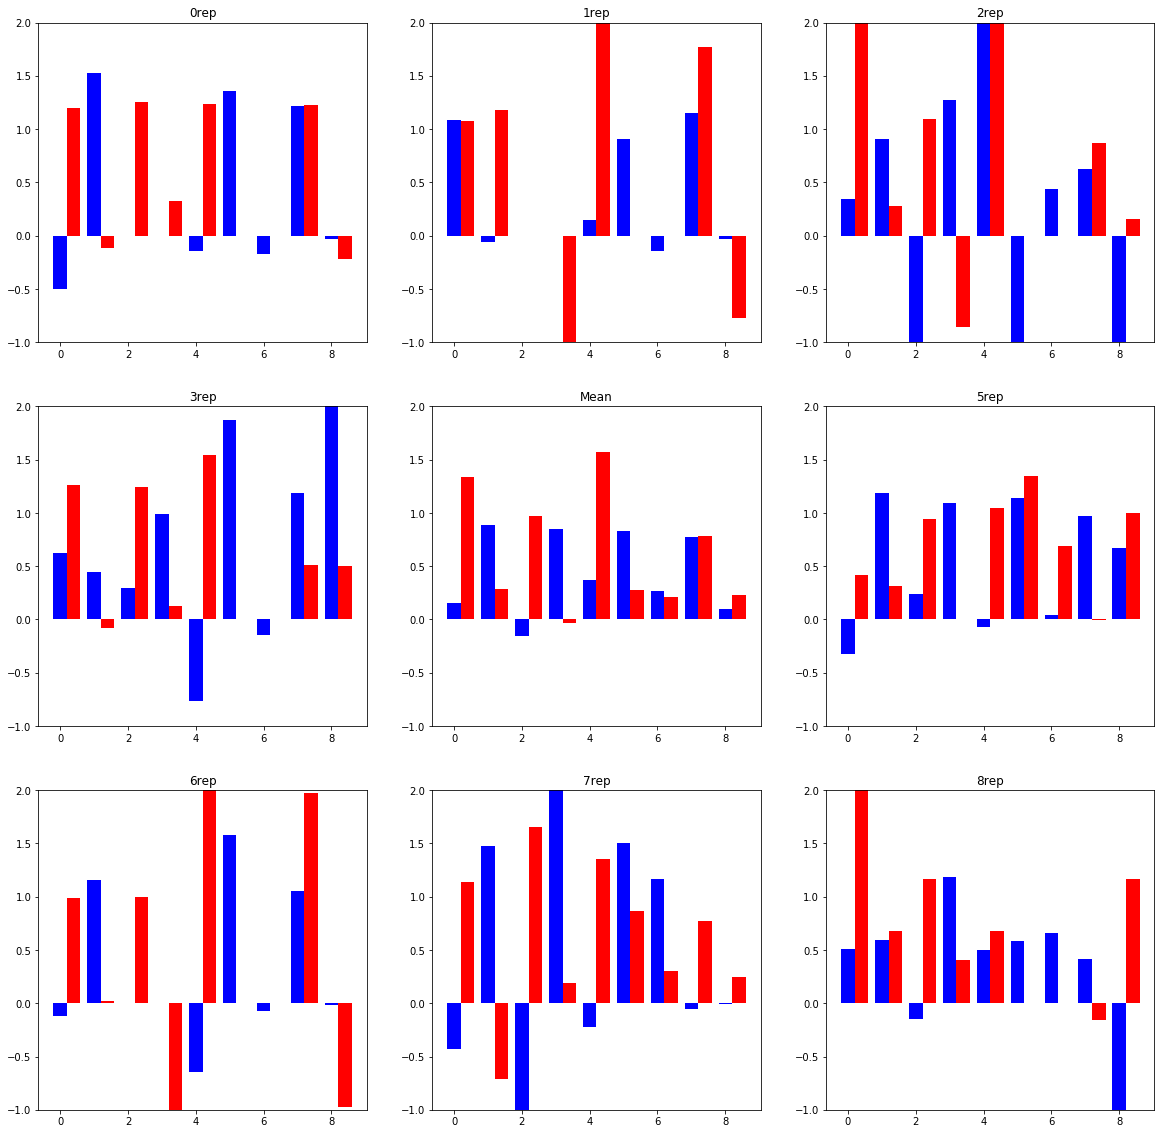

5000


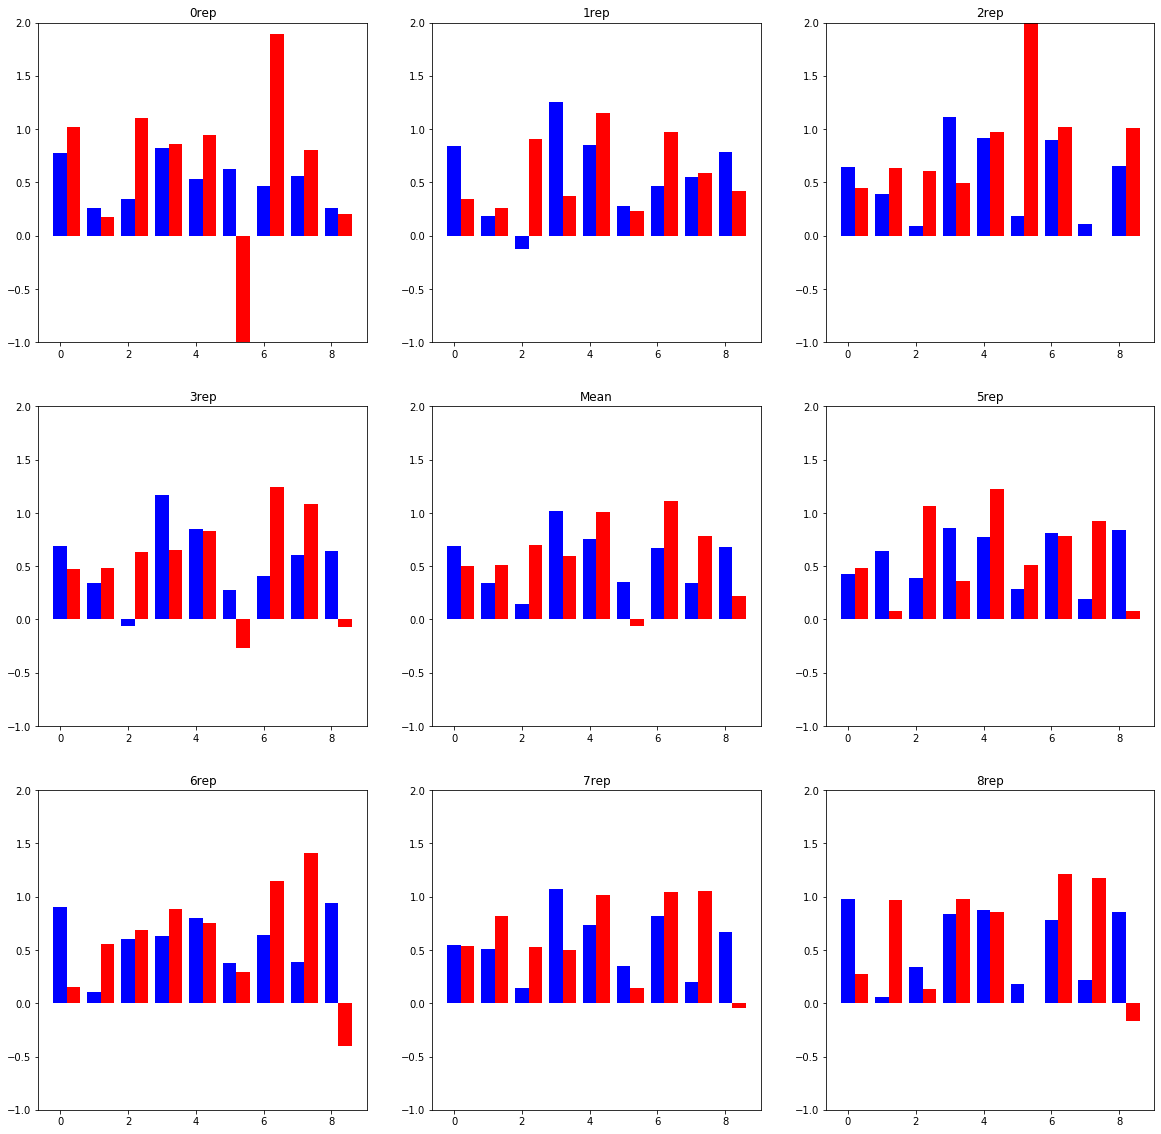

50000


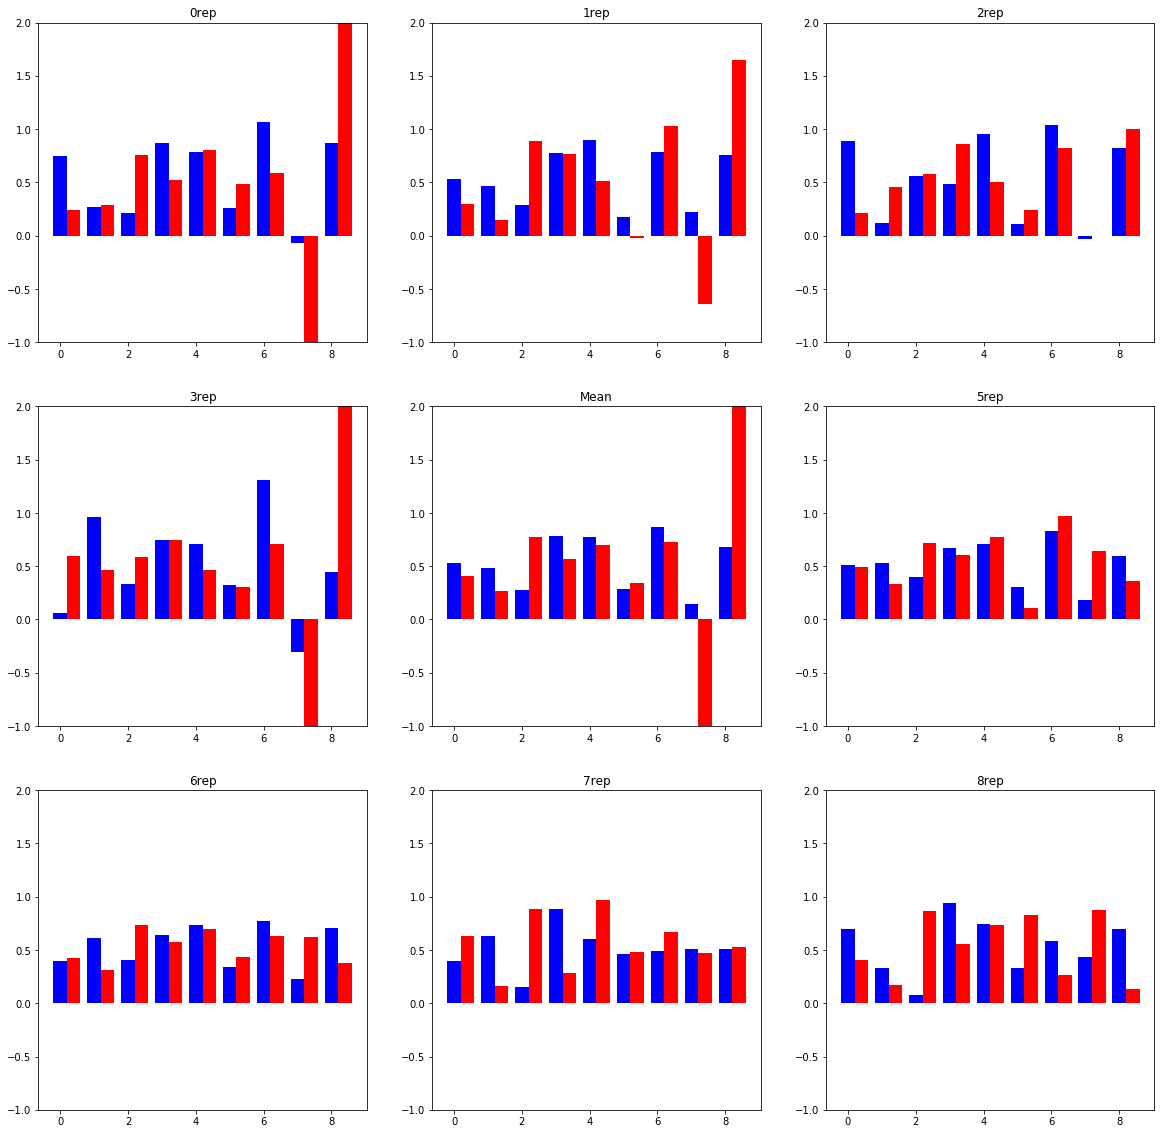

162946


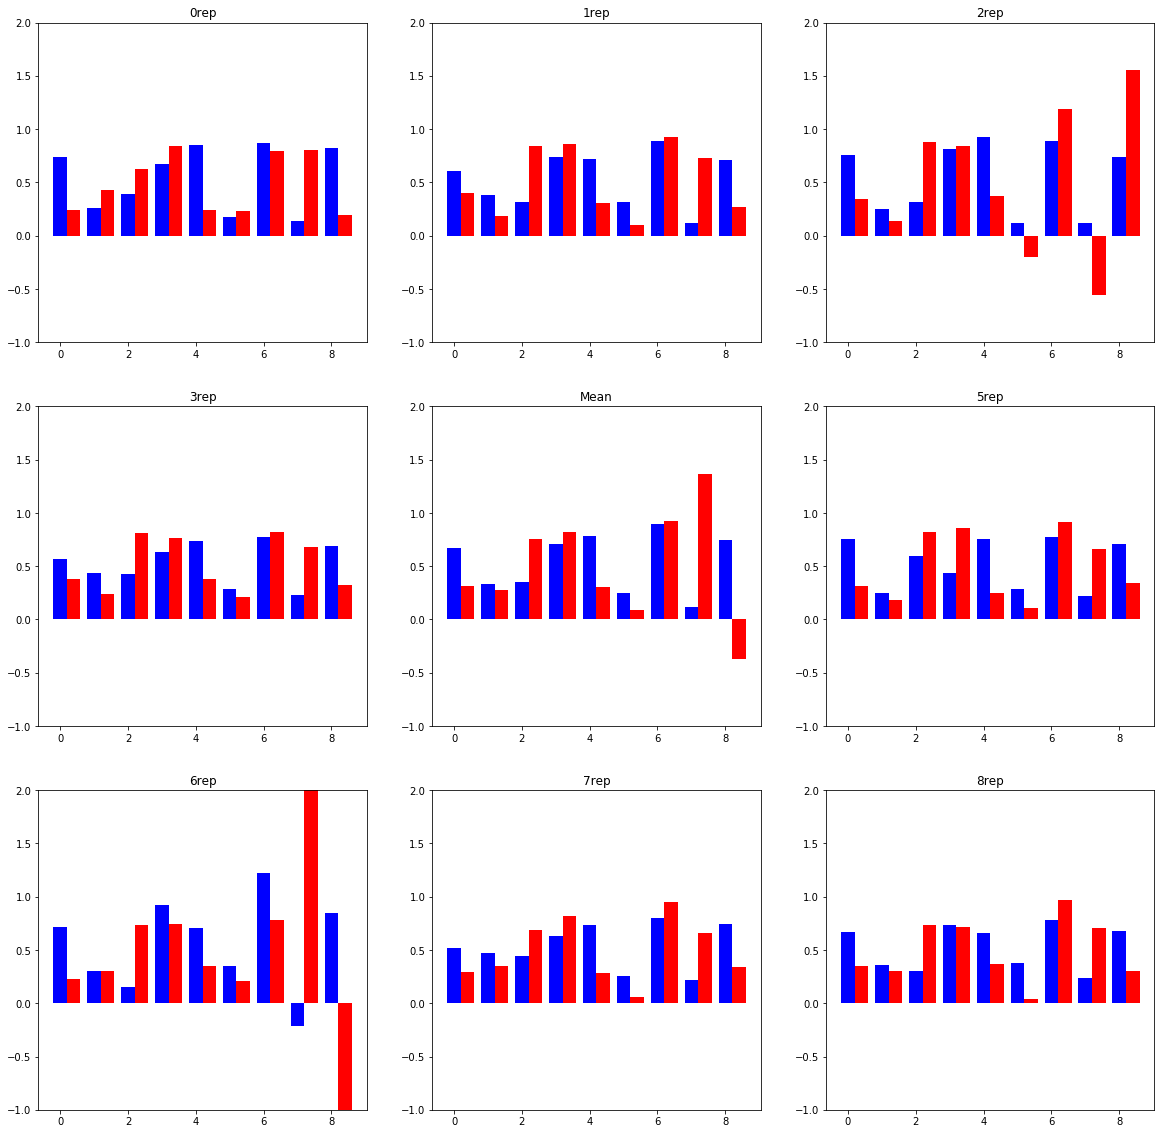

In [161]:
data_size_list = [500,5000,50000,162946]


for data_size in data_size_list:
    coeff_sum = coeff_dict[data_size][9]
    for i in range(9):
        coeff_sum = np.add(coeff_sum, coeff_dict[data_size][i])
    coeff_mean = np.divide(coeff_sum,10)
    
    fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for rep in range(9):
        if rep != 4:
            coeff = np.array(coeff_dict[data_size])[rep]
            co_list = []
            for k in range(9):
                co_list.append(coeff[k][k])
                co_list.append(coeff[k][k+9])

            bar_width = 0.4
            ax[rep].bar(np.arange(9), co_list[:9],bar_width, color='b')
            ax[rep].bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
            ax[rep].title.set_text(str(rep)+'rep')
            ax[rep].set_ylim(-1,2)
        else:
            
            coeff = np.array(coeff_mean)
            co_list = []
            for k in range(9):
                co_list.append(coeff[k][k])
                co_list.append(coeff[k][k+9])

            bar_width = 0.4
            ax[rep].bar(np.arange(9), co_list[:9],bar_width, color='b')
            ax[rep].bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
            ax[rep].title.set_text('Mean')
            ax[rep].set_ylim(-1,2)
            
    print(data_size)
    plt.show()
    

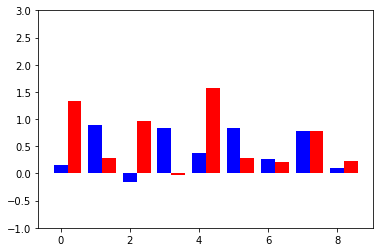

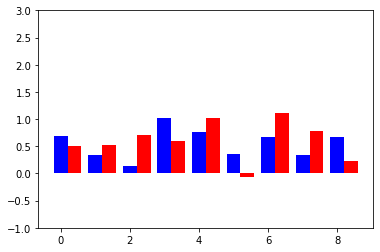

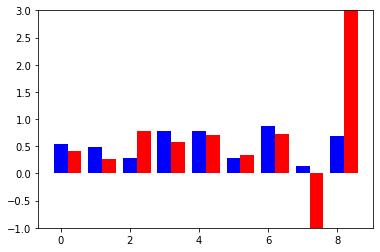

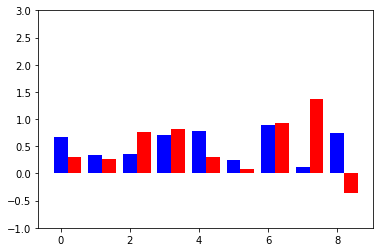

In [163]:
for data_size in data_size_list:
    coeff_sum = coeff_dict[data_size][9]
    for i in range(9):
        coeff_sum = np.add(coeff_sum, coeff_dict[data_size][i])
    coeff = np.divide(coeff_sum,10)
    co_list = []
    for k in range(9):
        co_list.append(coeff[k][k])
        co_list.append(coeff[k][k+9])
    r,c = rep % 3 , (rep- r) // 3

    bar_width = 0.4
    plt.bar(np.arange(9), co_list[:9],bar_width, color='b')
    plt.bar(np.arange(9)+bar_width, co_list[9:],bar_width, color='r')
    plt.ylim(-1,3)
    plt.show()